In [1]:
def print_section(text):
    print('##############################################')
    print('###  ', text)
    print('##############################################')


print_section('Start imports')
import importlib
import os
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import tqdm
import numpy as np
import pickle
import marshal
import pandas as pd
import matplotlib.cm as cm
import matplotlib.axes as am
import matplotlib.pyplot as plt
%matplotlib widget
import statsmodels.api as sm
import SALib
import SALib.analyze.sobol


import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer

from src.particle_funcs import distance_matrix as distance_matrix
from src.particle_funcs import io as particles_io
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import parameterstudy

from src import h5py_funcs
from src.h5py_funcs import inspections, discoveries, init_custom_getstates, io, parameterstudy_using_info_file

print_section('Finished imports')


##############################################
###   Start imports
##############################################
no cupy available, imported numpy as usual
Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.
##############################################
###   Finished imports
##############################################


In [2]:
import io
print('io.DEFAULT_BUFFER_SIZE', io.DEFAULT_BUFFER_SIZE)

io.DEFAULT_BUFFER_SIZE 8192


In [3]:
read_from = 'pickle'  # 'pickle' only, 'marshal' unmarshals numpy.ndarray as bytes-object and raises error when marshaling pathlib.Path objects
assert read_from == 'pickle', 'marshal unmarshals numpy.ndarray as bytes-object and raises error when marshaling pathlib.Path objects'
deserializer = ...
if read_from == 'pickle':
    deserializer = pickle
elif read_from == 'marshal':
    deserializer = marshal
else:
    raise ValueError(f'Unknown read_from value: {read_from}. Use "pickle" or "marshal".')

data_dir = pathlib.Path('03_inspect/01_data')

dict_files_information, dict_infos_read, dict_study, dict_success = \
{}, {}, {}, {}

files_to_read = {'dict_files_information': {'is_to_load': True },
                 'dict_infos_read'       : {'is_to_load': True },
                 'dict_study': {
                    1: {'is_to_load': True },
                    2: {'is_to_load': True },
                    3: {'is_to_load': True },
                    4: {'is_to_load': True },
                    5: {'is_to_load': True },
                    6: {'is_to_load': True },
                    7: {'is_to_load': True },
                    8: {'is_to_load': True }
                    },
                 'dict_success': {
                    1: {'is_to_load': False},
                    2: {'is_to_load': False},
                    3: {'is_to_load': False},
                    4: {'is_to_load': False},
                    5: {'is_to_load': False},
                    6: {'is_to_load': False},
                    7: {'is_to_load': False},
                    8: {'is_to_load': False}
                    }
                 }

In [4]:
for key, val in files_to_read.items():
    if key in ('dict_files_information', 'dict_infos_read'):
        exec(f'{key} = None')  # create variables dynamically
        if val['is_to_load']:
            file_name_path = data_dir.joinpath(key + '.' + 'pickle')
            print(f'Reading {key} from {file_name_path}')
            with open(file_name_path, 'rb') as f:
                exec(f'{key} = deserializer.load(f)')
    elif key in ('dict_study', 'dict_success'):
        exec(f'{key} = dict()')  # create variables dynamically
        for sub_key, sub_val in val.items():
            if sub_val['is_to_load']:
                file_name_path = data_dir.joinpath(f'{key}_{sub_key}'+ '.' + 'pickle')
                print(f'Reading {key}[{sub_key}] from {file_name_path}')
                with open(file_name_path, 'rb') as f:
                    exec(f'{key}[{sub_key}] = deserializer.load(f)')
            else:
                exec(f'{key}[{sub_key}] = None')
    else:
        raise ValueError(f'Unknown key: {key}. Check files_to_read')


Reading dict_files_information from 03_inspect/01_data/dict_files_information.pickle
Reading dict_infos_read from 03_inspect/01_data/dict_infos_read.pickle
Reading dict_study[1] from 03_inspect/01_data/dict_study_1.pickle
Reading dict_study[2] from 03_inspect/01_data/dict_study_2.pickle
Reading dict_study[3] from 03_inspect/01_data/dict_study_3.pickle
Reading dict_study[4] from 03_inspect/01_data/dict_study_4.pickle
Reading dict_study[5] from 03_inspect/01_data/dict_study_5.pickle
Reading dict_study[6] from 03_inspect/01_data/dict_study_6.pickle
Reading dict_study[7] from 03_inspect/01_data/dict_study_7.pickle
Reading dict_study[8] from 03_inspect/01_data/dict_study_8.pickle


In [5]:
def compute_sim_annealing_solution(study:int|None=None, substudy:int|None=None, num_particles:int=None, num_neighbours:int|None=None, qubos:dict|None=None):
    print_section('Obtain exact/correct solution via simulated annealing - Start')
    import ast
    import dwave.samplers
    if num_neighbours is None:
        num_neighbours = num_particles
    #num_particles = 5
    qubos_key = f'{num_particles}_{num_neighbours}'
    qubos_key_long = f'0{num_particles}_0{num_neighbours}'
    qubos_key_long_short = f'0{num_particles}_{num_neighbours}'
    qubos_key_short_long = f'{num_particles}_0{num_neighbours}'
    if qubos is None:
        _qubos = dict_infos_read[study][substudy]['qubos']
    else:
        _qubos = qubos
    if qubos_key in _qubos:
        #qubo = dict_infos_read[study][substudy]['qubos'][f'{num_particles}_{num_particles}']
        qubo = _qubos[qubos_key]
    elif qubos_key_long in _qubos:
        qubo = _qubos[qubos_key_long]
    elif qubos_key_long_short in _qubos:
        qubo = _qubos[qubos_key_long_short]
    elif qubos_key_short_long in _qubos:
        qubo = _qubos[qubos_key_short_long]
    else:
        raise ValueError(f'QUBO key {qubos_key} not found in provided qubo dict. Available keys: {list(_qubos.keys())}')

    #sim_annealing_sample = dimod.samplers.ExactSolver().sample_qubo(
    #    {ast.literal_eval(key): value['data'] for key, value in qubo.items()})
    sim_annealing_sample = dwave.samplers.SimulatedAnnealingSampler().sample_qubo(
        {ast.literal_eval(key): value['data'] for key, value in qubo.items()},
        num_reads=10000)
    sim_annealing_sample = sim_annealing_sample.aggregate() # accumulates number of occurences
    #print(type(sim_annealing_sample))
    exact_sol = sim_annealing_sample.record
    exact_sol.sort(order='energy')
    #print(exact_sol)
    print_section('Obtain correct solution via simulated annealing - Finished')
    return exact_sol
print(compute_sim_annealing_solution(study=2, substudy=0, num_particles=5, num_neighbours=5))
print(compute_sim_annealing_solution(qubos=dict_infos_read[1][0]['qubos'], num_particles=5, num_neighbours=3))

##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################
[([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.90205303,  87)
 ([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], -9.89043746, 102)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], -9.88628398,  92)
 ([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], -9.88406401,  96)
 ([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.88305524,  73)
 ([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], -9.88083528,  98)
 ([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], -9.88065613,  95)


In [6]:
for i, v in enumerate(dict_study[2]):
    for k2, v2 in v.items():
        print(i, k2)

0 zz_4593727025
0 zz_5807383795
0 zz_1958660811
0 zz_4977448398
0 zz_9861726400
0 zz_4018132467
0 zz_8564050917
0 zz_0774385663
0 zz_2404178199
0 zz_2608120291
0 zz_2432726480
0 zz_0998746293
0 zz_0732748750
0 zz_1064692411
0 zz_7077342806
0 zz_9150463428
0 zz_1796819985
0 zz_7013897896
0 zz_1423205692
0 zz_2474862592
0 zz_2282724113
0 zz_4288610339
0 zz_0484760364
0 zz_3223161463
0 zz_8103807342
0 zz_9722018590
0 zz_0776510773
0 zz_3828246484
0 zz_5235568123
0 zz_8673245415
0 zz_0314807620
0 zz_1930124932
0 zz_4801656389
0 zz_6729846563
0 zz_2140734774
0 zz_5331655260
0 zz_7102613420
0 zz_3778019146
0 zz_0121970642
0 zz_1910331181
0 zz_9846935178
0 zz_0023526387
0 zz_0911420757
0 zz_1803606211
0 zz_0884514502
0 zz_5769960721
0 zz_5792089191
0 zz_0907318371
0 zz_1003279652
0 zz_7788638695
0 zz_7814898618
0 zz_4415153621
0 zz_9943921963
0 zz_7685401782
0 zz_1923096856
0 zz_2869173249
0 zz_1497299024
0 zz_3059165134
0 zz_9201336918
0 zz_5866593381
0 zz_9155544030
0 zz_2400011609
0 zz_653

In [7]:
# print(type(dict_study_8))
# print(len(dict_study_8))
# print(type(dict_study_8[0]))
# print(list(dict_study_8[0].keys()))
# print(len(dict_study_8[0]['zz_3009019372']))
# print(len(dict_study_8[0]['zz_3009019372']['custom']))
# print(list(dict_study_8[0]['zz_3009019372']['custom'].keys()))
# print(len(dict_study_8[0]['zz_3009019372']['custom']['composite']))
# print(len(dict_study_8[0]['zz_3009019372']['custom']['sampleset']))
# print(len(dict_study_8[0]['zz_3009019372']['custom']['set_identifier']))


In [8]:
for study_key in dict_study.keys():
    # if study_key in [0,1,2]:
    #     continue
    if dict_study[study_key] is None:
        continue
    for i, v in enumerate(dict_study[study_key]):
        print(study_key, i)
        for k2, v2 in v.items():
            #print(i, k2, list(v2.keys()), list(v2['custom'].keys()))
            dict_study[study_key][i][k2] = v2['custom']
            #del v2['custom']
# for k2, v2 in dict_study[2][0].items():
#     print(i, k2, list(v2.keys()), list(v2['custom'].keys()))
#     dict_study[2][0][k2] = v2['custom']
    #del v2['custom']

1 0
2 0
3 0
3 1
4 0
4 1
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
7 4
8 0


In [9]:

for i, v in enumerate(dict_study[2]):
    for k2, v2 in v.items():
        print(i, k2)
        for k3, v3 in v2.items():
            print(' ', k3)

0 zz_4593727025
  composite
  sampleset
  set_identifier
0 zz_5807383795
  composite
  sampleset
  set_identifier
0 zz_1958660811
  composite
  sampleset
  set_identifier
0 zz_4977448398
  composite
  sampleset
  set_identifier
0 zz_9861726400
  composite
  sampleset
  set_identifier
0 zz_4018132467
  composite
  sampleset
  set_identifier
0 zz_8564050917
  composite
  sampleset
  set_identifier
0 zz_0774385663
  composite
  sampleset
  set_identifier
0 zz_2404178199
  composite
  sampleset
  set_identifier
0 zz_2608120291
  composite
  sampleset
  set_identifier
0 zz_2432726480
  composite
  sampleset
  set_identifier
0 zz_0998746293
  composite
  sampleset
  set_identifier
0 zz_0732748750
  composite
  sampleset
  set_identifier
0 zz_1064692411
  composite
  sampleset
  set_identifier
0 zz_7077342806
  composite
  sampleset
  set_identifier
0 zz_9150463428
  composite
  sampleset
  set_identifier
0 zz_1796819985
  composite
  sampleset
  set_identifier
0 zz_7013897896
  composite
  s

In [10]:
importlib.reload(inspections)
importlib.reload(inspections.stats)

<module 'src.h5py_funcs._statistics' from '/mnt/userdrive/Users/home/adam-1aeqn8vhvpjnv4u/git_repos/Quantum_Annealing_for_Particle_Matching/src/h5py_funcs/_statistics.py'>

In [11]:
df = pd.DataFrame.from_dict(dict_study[2][0], orient='index').reset_index(names=['set_id'])
df.head()

set_id                                          composite  \
0  zz_4593727025  {'children': {'child_0': {'_adjacency': {'100'...   
1  zz_5807383795  {'children': {'child_0': {'_adjacency': {'100'...   
2  zz_1958660811  {'children': {'child_0': {'_adjacency': {'100'...   
3  zz_4977448398  {'children': {'child_0': {'_adjacency': {'100'...   
4  zz_9861726400  {'children': {'child_0': {'_adjacency': {'100'...   

                                           sampleset  \
0  {'000_0142': {'_info': {'embedding_context': {...   
1  {'000_0166': {'_info': {'embedding_context': {...   
2  {'000_0142': {'_info': {'embedding_context': {...   
3  {'000_0090': {'_info': {'embedding_context': {...   
4  {'000_0090': {'_info': {'embedding_context': {...   

                            set_identifier  
0  {'attrs': {}, 'data': b'zz_4593727025'}  
1  {'attrs': {}, 'data': b'zz_5807383795'}  
2  {'attrs': {}, 'data': b'zz_1958660811'}  
3  {'attrs': {}, 'data': b'zz_4977448398'}  
4  {'attrs': {}, 'data': b'zz_9861726400'}

In [12]:
list(df.at[0, 'sampleset'].keys())

['000_0142',
 '000_0148',
 '001_0142',
 '001_0148',
 '002_0142',
 '002_0148',
 '003_0142',
 '003_0148',
 '004_0142',
 '004_0148',
 '005_0142',
 '005_0148',
 '006_0142',
 '006_0148',
 '007_0142',
 '007_0148',
 '008_0142',
 '008_0148',
 '009_0142',
 '009_0148']

In [13]:
list(df.at[0, 'sampleset']['000_0142'].keys())

['_info', '_record', '_variables']

In [14]:
df.at[0, 'sampleset']['000_0142']['_info']

{'embedding_context': {'chain_break_method': {'attrs': {},
   'data': b'majority_vote'},
  'chain_strength': {'attrs': {}, 'data': np.float64(3.999395954391113)},
  'embedding': {'(1, 1)': {'attrs': {},
    'data': array([1026, 1027], dtype=int32)},
   '(1, 2)': {'attrs': {}, 'data': array([4340, 4339], dtype=int32)},
   '(1, 3)': {'attrs': {}, 'data': array([ 997, 4370, 4371], dtype=int32)},
   '(1, 4)': {'attrs': {}, 'data': array([1162, 4355], dtype=int32)},
   '(1, 5)': {'attrs': {}, 'data': array([1012, 1011, 4114], dtype=int32)},
   '(2, 1)': {'attrs': {}, 'data': array([4205,  952], dtype=int32)},
   '(2, 2)': {'attrs': {}, 'data': array([937], dtype=int32)},
   '(2, 3)': {'attrs': {}, 'data': array([4236, 4235, 1252], dtype=int32)},
   '(2, 4)': {'attrs': {}, 'data': array([4250, 1057], dtype=int32)},
   '(2, 5)': {'attrs': {}, 'data': array([ 981, 4189], dtype=int32)},
   '(3, 1)': {'attrs': {}, 'data': array([4325, 1072, 4324], dtype=int32)},
   '(3, 2)': {'attrs': {}, 'data'

In [15]:
# Skip composite column for now
#df.at[0, 'composite']
df.query('@df[\'set_id\']==\'zz_4593727025\'')

set_id                                          composite  \
0  zz_4593727025  {'children': {'child_0': {'_adjacency': {'100'...   

                                           sampleset  \
0  {'000_0142': {'_info': {'embedding_context': {...   

                            set_identifier  
0  {'attrs': {}, 'data': b'zz_4593727025'}

In [16]:
# print(list(dict_infos_read[2][0].keys()))
# print(dict_infos_read[2][0]['attrs'])
# print(type(dict_infos_read[2][0]['study']['data']))
# print(dict_infos_read[2][0]['study']['data'].dtype)
# print(dict_infos_read[2][0]['study']['data'].ndim)
# print(type(dict_infos_read[2][0]['study']['data']['sets']))
# print(dict_infos_read[2][0]['study']['data']['sets'].dtype)
# print(dict_infos_read[2][0]['study']['data']['sets'].ndim)
# print(dict_infos_read[2][0]['study']['data']['sets'].shape)
# print(dict_infos_read[2][0]['study']['data']['sets'][:,0])
# print(dict_infos_read[2][0]['study']['data']['sets'])

# dict_infos_read[2][0]['study']['data']['sets'] = dict_infos_read[2][0]['study']['data']['sets'].copy()
# print(dict_infos_read[2][0]['study']['data']['sets'].dtype)
# print(dict_infos_read[2][0]['study']['data']['sets'].ndim)
# print(dict_infos_read[2][0]['study']['data']['sets'].shape)
# print(dict_infos_read[2][0]['study']['data']['sets'])
# a = np.ascontiguousarray(dict_infos_read[2][0]['study']['data'])
# a.resize((2048,))
# a.ndim
# a['sets'].shape


In [17]:
#df_params_from_info = pd.DataFrame.from_records(dict_infos_read[2][0]['study']['data']['sets'][:,0], index=dict_infos_read[2][0]['study']['data']['identifiers'])
dict_df_params_from_info = {}
dict_substudies_need_merge = {}
for key, val in dict_study.items():
    dict_df_params_from_info[key] = None
    dict_substudies_need_merge[key] = None
    print(key)
    if val is not None:
        dict_df_params_from_info[key] = []
        dict_substudies_need_merge[key] = [[0]]
        study_id = key
        for substudy_id in range(len(dict_infos_read[study_id])):
            dict_df_params_from_info[key].append(None)
            study_info = dict_infos_read[study_id][substudy_id]['study']['data']
            study_info_data_sets = dict_infos_read[study_id][substudy_id]['study']['data']['sets']
            dtype_names = study_info_data_sets.dtype.names
            print(dtype_names)
            if study_info_data_sets.ndim == 1:
                study_info_data_sets = np.atleast_2d(study_info_data_sets).T # Transpose because np.atleast_2d does (n,) -> (1, n), but we need (n, 1) to be consistent
            dict_df_params_from_info[study_id][substudy_id] = pd.DataFrame(dict_infos_read[study_id][substudy_id]['study']['data']['identifiers'], columns=['identifiers']).merge(
                            pd.DataFrame(study_info_data_sets[:,0]), left_index=True, right_index=True)
            dict_df_params_from_info[study_id][substudy_id]['identifiers'] = dict_df_params_from_info[study_id][substudy_id]['identifiers'].apply(lambda id: id.decode('utf-8'))
            _shape = dict_df_params_from_info[study_id][substudy_id].shape
            if substudy_id > 0:
                _is_equal_to_previous = dict_df_params_from_info[study_id][substudy_id].equals(dict_df_params_from_info[study_id][substudy_id-1])
                if _is_equal_to_previous:
                    dict_substudies_need_merge[study_id][-1].append(substudy_id)
                else:
                    dict_substudies_need_merge[study_id].append([substudy_id])
                print(_shape, end=' ')
                print('  is equal to previous substudy:', _is_equal_to_previous)
            else:
                print(_shape)
dict_substudies_need_merge

1
('num_particles', 'num_nearest_neighbours')
(29, 3)
2
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
(2048, 5)
3
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
(512, 5)
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
(512, 5)   is equal to previous substudy: True
4
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
(512, 5)
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
(512, 5)   is equal to previous substudy: True
5
('chain_strength', 'estimated_runtime')
(1000, 3)
('chain_strength', 'estimated_runtime')
(1000, 3)   is equal to previous substudy: False
('anneal_offsets_1_qubits', 'anneal_offsets_2_qubits', 'anneal_offsets_3_qubits', 'estimated_runtime')
(4096, 5)   is equal to previous substudy: False
('anneal_offsets_1_qubits', 'anneal_offsets_2

{1: [[0]],
 2: [[0]],
 3: [[0, 1]],
 4: [[0, 1]],
 5: [[0], [1], [2], [3, 4]],
 6: [[0, 1], [2, 3]],
 7: [[0, 1, 2, 3, 4]],
 8: [[0]]}

In [18]:


dict_study_merged_substudies = {}
for key, val in dict_study.items():
    print(key)
    dict_study_merged_substudies[key] = []
    if len(dict_substudies_need_merge[key]) == 0:
        print(f'Study {key} does not require merge.')
        dict_study_merged_substudies[key].append(dict_study[key][0])
        continue

    for ids_to_merge in dict_substudies_need_merge[key]:
        merged_ids = []
        merged_dict = {}
        print(f'IDs to merge: {ids_to_merge}')
        for id in ids_to_merge:
            print(f'ID {id} not merged, merge now to', merged_ids)
            for key_dict_1 in merged_dict.keys():
                if key_dict_1 in list(dict_study[key][id].keys()):
                    raise ValueError(f'Problem merging substudy {id} because {key_dict_1} already exists in merged_dict.')
            merged_dict.update(dict_study[key][id])
            merged_ids.append(id)
        dict_study_merged_substudies[key].append(merged_dict)

1
IDs to merge: [0]
ID 0 not merged, merge now to []
2
IDs to merge: [0]
ID 0 not merged, merge now to []
3
IDs to merge: [0, 1]
ID 0 not merged, merge now to []
ID 1 not merged, merge now to [0]
4
IDs to merge: [0, 1]
ID 0 not merged, merge now to []
ID 1 not merged, merge now to [0]
5
IDs to merge: [0]
ID 0 not merged, merge now to []
IDs to merge: [1]
ID 1 not merged, merge now to []
IDs to merge: [2]
ID 2 not merged, merge now to []
IDs to merge: [3, 4]
ID 3 not merged, merge now to []
ID 4 not merged, merge now to [3]
6
IDs to merge: [0, 1]
ID 0 not merged, merge now to []
ID 1 not merged, merge now to [0]
IDs to merge: [2, 3]
ID 2 not merged, merge now to []
ID 3 not merged, merge now to [2]
7
IDs to merge: [0, 1, 2, 3, 4]
ID 0 not merged, merge now to []
ID 1 not merged, merge now to [0]
ID 2 not merged, merge now to [0, 1]
ID 3 not merged, merge now to [0, 1, 2]
ID 4 not merged, merge now to [0, 1, 2, 3]
8
IDs to merge: [0]
ID 0 not merged, merge now to []


In [19]:
for key in dict_study_merged_substudies.keys():
    print(len(dict_study_merged_substudies[key]))

1
1
1
1
4
2
1
1


In [20]:
dict_success_2_local = inspections.extract_success_dict(dict_for_df=dict_study[2][0],
                                                        exact_sols=compute_sim_annealing_solution(study=2, substudy=0, num_particles=5),
                                                        n_samples_to_compare=10, n_exact_sols_to_compare=10, is_skip_custom_key_in_dict_for_df=True)
dict_success_2_local

##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################


{'zz_4593727025': {'is_found_best': np.True_,
  'num_runs_is_found_best': np.int64(9),
  'num_samples_is_found_best': np.int32(32),
  'num_samples_is_found_best_per_run': [np.int32(2),
   0,
   np.int32(1),
   np.int32(4),
   np.int32(3),
   np.int32(6),
   np.int32(5),
   np.int32(4),
   np.int32(3),
   np.int32(4)],
  'is_found_best_per_run': [True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True],
  'num_samples': np.int64(2900),
  'num_runs': 10,
  'num_subs_per_run': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  'num_samples_per_run': [np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290),
   np.int64(290)],
  'num_samples_per_sub_per_run': [[np.int64(142), np.int64(148)],
   [np.int64(142), np.int64(148)],
   [np.int64(142), np.int64(148)],
   [np.int64(142), np.int64(148)],
   [np.int64(142), np.int64(148)],
   [np.int64(142), np.int64(148)],
   [np.int64(

In [21]:
dict_success_local = {}
for study_key in dict_study.keys():
    dict_success_local[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_study[study_key] is not None:
        for substudy_key in range(len(dict_study[study_key])):
            print(f'  Processing substudy {substudy_key}...')
            dict_success_local[study_key][substudy_key] = inspections.extract_success_dict(dict_for_df=dict_study[study_key][substudy_key],
                                                        exact_sols=compute_sim_annealing_solution(study=study_key, substudy=substudy_key, num_particles=5),
                                                        n_samples_to_compare=10, n_exact_sols_to_compare=10, is_skip_custom_key_in_dict_for_df=True)
    else:
        dict_success_local[study_key] = None

Processing study 1...
  Processing substudy 0...
##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################
Processing study 2...
  Processing substudy 0...
##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################
Processing study 3...
  Processing substudy 0...
##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
##

In [22]:
def extract_success_dict_study_1(dict_for_df:dict=None, n_samples_to_compare:int=0, n_exact_sols_to_compare:int=0,
                         is_skip_custom_key_in_dict_for_df:bool=False, is_print_sols:bool=False, is_print_meta:bool=False, print_prefix:str=' '):
    dict_success_dicts = {}
    print(f'Extract {dict_infos_read[1][0]['study']['data'].shape[0]} success dicts from study 1...')
    for row_id in range(dict_infos_read[1][0]['study']['data'].shape[0]):
        _num_particels = dict_infos_read[1][0]['study']['data']['sets'][row_id]['num_particles'][0]
        _num_neighbours = dict_infos_read[1][0]['study']['data']['sets'][row_id]['num_nearest_neighbours'][0]
        _id = dict_infos_read[1][0]['study']['data']['identifiers'][row_id]
        print(f'  Processing num_particles={_num_particels}, num_neighbours={_num_neighbours} for id={_id}')
        #if _num_particels>=6: 
        #    continue
        exact_sols = compute_sim_annealing_solution(qubos=dict_infos_read[1][0]['qubos'], num_particles=_num_particels, num_neighbours=_num_neighbours)
        
        #dict_success_dicts[_id.decode('utf-8')] = inspections.extract_success_dict(dict_for_df=dict_for_df,
        dict_success_dicts.update( inspections.extract_success_dict(dict_for_df=dict_for_df,
                                                             exact_sols=exact_sols,
                                                             n_samples_to_compare=n_samples_to_compare,
                                                             n_exact_sols_to_compare=n_exact_sols_to_compare,
                                                             is_skip_custom_key_in_dict_for_df=is_skip_custom_key_in_dict_for_df,
                                                             is_print_sols=is_print_sols, is_print_meta=is_print_meta, print_prefix=print_prefix + ' '))
    return dict_success_dicts    
    

In [23]:
dict_success_local_from_merged_studies = {}
n_samples_to_compare = 10
n_exact_sols_to_compare = 10
is_skip_custom_key_in_dict_for_df = True
for study_key in dict_study_merged_substudies.keys():
    dict_success_local_from_merged_studies[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_study_merged_substudies[study_key] is not None and study_key != 1:
        for merged_substudies_key in range(len(dict_study_merged_substudies[study_key])):
            print(f'  Processing merged substudies {merged_substudies_key}...i.e. substudies {dict_substudies_need_merge[study_key][merged_substudies_key]}')
            dict_success_local_from_merged_studies[study_key][merged_substudies_key] = inspections.extract_success_dict(dict_for_df=dict_study_merged_substudies[study_key][merged_substudies_key],
                                                        exact_sols=compute_sim_annealing_solution(study=study_key, substudy=dict_substudies_need_merge[study_key][merged_substudies_key][0], num_particles=5),
                                                        n_samples_to_compare=n_samples_to_compare, n_exact_sols_to_compare=n_exact_sols_to_compare, is_skip_custom_key_in_dict_for_df=is_skip_custom_key_in_dict_for_df)
    elif dict_study_merged_substudies[study_key] is not None and study_key == 1:
        for merged_substudies_key in range(len(dict_study_merged_substudies[study_key])):
            dict_success_local_from_merged_studies[study_key][merged_substudies_key] = extract_success_dict_study_1(dict_for_df=dict_study_merged_substudies[study_key][0], n_samples_to_compare=n_samples_to_compare, 
                                                                                n_exact_sols_to_compare=n_exact_sols_to_compare, is_skip_custom_key_in_dict_for_df=is_skip_custom_key_in_dict_for_df)
    else:
        dict_success_local_from_merged_studies[study_key] = None

Processing study 1...
Extract 29 success dicts from study 1...
  Processing num_particles=5, num_neighbours=5 for id=b'zz_5703083384'
##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################
  Processing num_particles=5, num_neighbours=4 for id=b'zz_5457588972'
##############################################
###   Obtain exact/correct solution via simulated annealing - Start
##############################################
##############################################
###   Obtain correct solution via simulated annealing - Finished
##############################################
  Processing num_particles=5, num_neighbours=3 for id=b'zz_1897573298'
##############################################
###   Obtain exact/correct solution

In [24]:
print(list(dict_success_local_from_merged_studies[1][0].keys()))
print(dict_success_local_from_merged_studies[1][0]['zz_5703083384'])

['zz_5703083384', 'zz_5457588972', 'zz_1897573298', 'zz_8272243285', 'zz_1070242504', 'zz_9469440848', 'zz_1692397523', 'zz_4165436873', 'zz_9880612622', 'zz_6856154368', 'zz_4931925256', 'zz_2057909975', 'zz_0054522459', 'zz_4885882981', 'zz_3979500108', 'zz_3088371157', 'zz_8129145255', 'zz_4435430247', 'zz_4179325359', 'zz_4076809715', 'zz_5334518067', 'zz_5412174942', 'zz_6018269281', 'zz_1561967451', 'zz_7127866328', 'zz_8171500250', 'zz_1908483939', 'zz_6057258587', 'zz_5706799265']
{'is_found_best': np.False_, 'num_runs_is_found_best': np.int64(0), 'num_samples_is_found_best': 0, 'num_samples_is_found_best_per_run': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'is_found_best_per_run': [False, False, False, False, False, False, False, False, False, False], 'num_samples': np.int64(10000), 'num_runs': 10, 'num_subs_per_run': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'num_samples_per_run': [np.int64(1000), np.int64(1000), np.int64(1000), np.int64(1000), np.int64(1000), np.int64(1000), np.int64(1000), np.i

In [25]:
print(list(dict_study_merged_substudies[3][0].keys()))
print(dict_success_local_from_merged_studies[3][0]['zz_0594500236'])

['zz_0594500236', 'zz_8399935511', 'zz_8254472835', 'zz_5764679840', 'zz_0210405625', 'zz_9579793783', 'zz_9568089288', 'zz_0562826232', 'zz_0922653251', 'zz_2434077918', 'zz_2871450148', 'zz_8798000343', 'zz_9357211953', 'zz_6580697660', 'zz_6408592024', 'zz_8383268435', 'zz_0497928876', 'zz_6726194657', 'zz_6629375788', 'zz_4041835465', 'zz_9144036899', 'zz_7631550656', 'zz_2038950416', 'zz_1161068603', 'zz_7253153800', 'zz_2927355622', 'zz_6809108860', 'zz_1638988001', 'zz_8677621521', 'zz_1426986117', 'zz_6519846298', 'zz_6753648971', 'zz_7113932168', 'zz_8093166368', 'zz_3595284705', 'zz_8115207891', 'zz_7406910559', 'zz_0470282487', 'zz_6072268519', 'zz_2751579513', 'zz_6267210246', 'zz_9120108892', 'zz_9283105305', 'zz_6570843060', 'zz_3740505924', 'zz_0859115108', 'zz_9068195746', 'zz_5986609357', 'zz_2282652989', 'zz_4724076768', 'zz_6684243645', 'zz_0760343573', 'zz_6688397866', 'zz_1357332004', 'zz_6262717099', 'zz_4561369957', 'zz_7511325543', 'zz_5152156763', 'zz_164468124

In [26]:
len(dict_success_local_from_merged_studies[3][0])

512

In [27]:
df_success_2_local = pd.DataFrame.from_dict(dict_success_2_local, orient='index').reset_index(names=['set_id'])
print(df_success_2_local.head())

          set_id  is_found_best  num_runs_is_found_best  \
0  zz_4593727025           True                       9   
1  zz_5807383795           True                      10   
2  zz_1958660811           True                       8   
3  zz_4977448398           True                       8   
4  zz_9861726400           True                       9   

   num_samples_is_found_best num_samples_is_found_best_per_run  \
0                         32    [2, 0, 1, 4, 3, 6, 5, 4, 3, 4]   
1                         29    [5, 4, 3, 2, 2, 2, 2, 2, 5, 2]   
2                         33    [4, 7, 1, 3, 8, 0, 4, 0, 3, 3]   
3                         28    [3, 3, 3, 0, 5, 5, 3, 1, 5, 0]   
4                         23    [2, 0, 2, 1, 1, 3, 2, 2, 9, 1]   

                               is_found_best_per_run  num_samples  num_runs  \
0  [True, False, True, True, True, True, True, Tr...         2900        10   
1  [True, True, True, True, True, True, True, Tru...         3360        10   
2  [True, T

In [28]:
df_success_2_merged_local = pd.DataFrame.from_dict(dict_success_local_from_merged_studies[3][0], orient='index').reset_index(names=['set_id'])
print(df_success_2_merged_local.head())

          set_id  is_found_best  num_runs_is_found_best  \
0  zz_0594500236           True                      10   
1  zz_8399935511           True                      10   
2  zz_8254472835           True                      10   
3  zz_5764679840           True                      10   
4  zz_0210405625           True                      10   

   num_samples_is_found_best      num_samples_is_found_best_per_run  \
0                        145  [9, 17, 18, 23, 13, 21, 10, 9, 8, 17]   
1                        112  [16, 6, 11, 15, 14, 13, 10, 13, 6, 8]   
2                        121  [13, 14, 10, 10, 16, 23, 8, 9, 7, 11]   
3                        108  [8, 11, 9, 12, 10, 14, 11, 10, 17, 6]   
4                        123   [12, 10, 9, 12, 7, 19, 6, 12, 30, 6]   

                               is_found_best_per_run  num_samples  num_runs  \
0  [True, True, True, True, True, True, True, Tru...        10000        10   
1  [True, True, True, True, True, True, True, Tru...        

In [29]:
dict_df_success_local =  {}
for study_key in dict_study.keys():
    dict_df_success_local[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_success_local[study_key] is not None:
        for substudy_key in range(len(dict_success_local[study_key])):
            print(f'  Processing substudy {substudy_key}...')
            dict_df_success_local[study_key][substudy_key] = pd.DataFrame.from_dict(dict_success_local[study_key][substudy_key], orient='index').reset_index(names=['set_id'])
            print(dict_df_success_local[study_key][substudy_key].head())
    else:
        dict_df_success_local[study_key] = None

Processing study 1...
  Processing substudy 0...
          set_id  is_found_best  num_runs_is_found_best  \
0  zz_5703083384           True                      10   
1  zz_5457588972          False                       0   
2  zz_1897573298          False                       0   
3  zz_8272243285          False                       0   
4  zz_1070242504          False                       0   

   num_samples_is_found_best      num_samples_is_found_best_per_run  \
0                        223  [39, 40, 30, 1, 1, 44, 32, 17, 18, 1]   
1                          0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2                          0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3                          0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4                          0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                               is_found_best_per_run  num_samples  num_runs  \
0  [True, True, True, True, True, True, True, Tru...        10000        10   
1  [False, 

In [30]:
dict_success_local_from_merged_studies[1][0]

{'zz_5703083384': {'is_found_best': np.False_,
  'num_runs_is_found_best': np.int64(0),
  'num_samples_is_found_best': 0,
  'num_samples_is_found_best_per_run': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'is_found_best_per_run': [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  'num_samples': np.int64(10000),
  'num_runs': 10,
  'num_subs_per_run': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'num_samples_per_run': [np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000),
   np.int64(1000)],
  'num_samples_per_sub_per_run': [[np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)],
   [np.int64(1000)]],
  'num_matched': 0,
  'num_matched_per_run': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'num_matched_per_sub_per_run': [[0],
   

In [31]:
dict_df_success_local_from_merged_studies =  {}
for study_key in dict_study.keys():
    dict_df_success_local_from_merged_studies[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_success_local_from_merged_studies[study_key] is not None:
        for merged_substudies_key in range(len(dict_success_local_from_merged_studies[study_key])):
            print(f'  Processing merged substudies {merged_substudies_key}...')
            dict_df_success_local_from_merged_studies[study_key][merged_substudies_key] = pd.DataFrame.from_dict(dict_success_local_from_merged_studies[study_key][merged_substudies_key], orient='index').reset_index(names=['set_id'])
            print(dict_df_success_local_from_merged_studies[study_key][merged_substudies_key].shape)
    else:
        dict_df_success_local_from_merged_studies[study_key] = None
dict_df_success_local_from_merged_studies[7][0].head()

Processing study 1...
  Processing merged substudies 0...
(29, 21)
Processing study 2...
  Processing merged substudies 0...
(464, 21)
Processing study 3...
  Processing merged substudies 0...
(512, 21)
Processing study 4...
  Processing merged substudies 0...
(512, 21)
Processing study 5...
  Processing merged substudies 0...
(1000, 21)
  Processing merged substudies 1...
(998, 21)
  Processing merged substudies 2...
(4095, 21)
  Processing merged substudies 3...
(4096, 21)
Processing study 6...
  Processing merged substudies 0...
(2600, 21)
  Processing merged substudies 1...
(2600, 21)
Processing study 7...
  Processing merged substudies 0...
(2816, 21)
Processing study 8...
  Processing merged substudies 0...
(352, 21)


set_id  is_found_best  num_runs_is_found_best  \
0  zz_8097006340           True                      10   
1  zz_3271526003           True                      10   
2  zz_5771100733           True                      10   
3  zz_6926620307           True                      10   
4  zz_0035448496           True                      10   

   num_samples_is_found_best num_samples_is_found_best_per_run  \
0                         24    [3, 3, 2, 3, 3, 3, 1, 2, 3, 1]   
1                         24    [2, 2, 2, 3, 1, 2, 3, 3, 3, 3]   
2                         24    [2, 2, 2, 2, 3, 3, 1, 3, 3, 3]   
3                         10    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
4                         22    [1, 3, 1, 3, 2, 2, 1, 3, 3, 3]   

                               is_found_best_per_run  num_samples  num_runs  \
0  [True, True, True, True, True, True, True, Tru...        10000        10   
1  [True, True, True, True, True, True, True, Tru...        10000        10   
2  [True, True, True, True, True, True, True, Tru...        10000        10   
3  [True, True, True, True, True, True, True, Tru...        10000        10   
4  [True, True, True, True, True, True, True, Tru...        10000        10   

                 num_subs_per_run  \
0  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
1  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
2  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
4  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   

                                 num_samples_per_run  ... num_matched  \
0  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...  ...         300   
1  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...  ...         300   
2  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...  ...         300   
3  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...  ...         100   
4  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...  ...         300   

                        num_matched_per_run  \
0  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
1  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
2  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
3  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]   
4  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   

                         num_matched_per_sub_per_run num_samples_matched  \
0  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...                 300   
1  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...                 300   
2  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...                 300   
3  [[10], [10], [10], [10], [10], [10], [10], [10...                 100   
4  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...                 300   

                num_samples_matched_per_run  \
0  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
1  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
2  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   
3  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]   
4  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]   

                 num_samples_matched_per_sub_per_run  \
0  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...   
1  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...   
2  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...   
3  [[10], [10], [10], [10], [10], [10], [10], [10...   
4  [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10...   

                                         submissions  \
0  {'000_0333_0001': {'num_samples': 333, 'is_fou...   
1  {'000_0333_0001': {'num_samples': 333, 'is_fou...   
2  {'000_0333_0001': {'num_samples': 333, 'is_fou...   
3  {'000_1000_0000': {'num_samples': 1000, 'is_fo...   
4  {'000_0333_0001': {'num_samples': 333, 'is_fou...   

  fraction_runs_is_found_best  fraction_samples_is_found_best  \
0                         1.0                          0.0024   
1                         1.0                          0.0024   
2                         1.0                          0.0024   
3                         1.0                          0.0010   
4                         1.0                          0.0022   

              fraction_samples_is

In [32]:
df_merged_params_success_2 = dict_df_params_from_info[2][0].merge(df_success_2_local, how='right', left_on='identifiers', right_on='set_id')
print(df_merged_params_success_2.shape)
df_merged_params_success_2.head()

(464, 26)


identifiers  annealing_time  programming_thermalization  \
0  zz_4593727025     1699.685865                 5652.846890   
1  zz_5807383795      465.346987                 5652.846890   
2  zz_1958660811     1699.685865                 5952.072199   
3  zz_4977448398     1699.685865                 5652.846890   
4  zz_9861726400     1699.685865                 5952.072199   

   readout_thermalization  estimated_runtime         set_id  is_found_best  \
0             3665.314559           5.504635  zz_4593727025           True   
1             3665.314559           4.270296  zz_5807383795           True   
2             3665.314559           5.504934  zz_1958660811           True   
3             6325.880662           8.165201  zz_4977448398           True   
4             6325.880662           8.165500  zz_9861726400           True   

   num_runs_is_found_best  num_samples_is_found_best  \
0                       9                         32   
1                      10                         29   
2                       8                         33   
3                       8                         28   
4                       9                         23   

  num_samples_is_found_best_per_run  ... num_matched  \
0    [2, 0, 1, 4, 3, 6, 5, 4, 3, 4]  ...         148   
1    [5, 4, 3, 2, 2, 2, 2, 2, 5, 2]  ...         146   
2    [4, 7, 1, 3, 8, 0, 4, 0, 3, 3]  ...         146   
3    [3, 3, 3, 0, 5, 5, 3, 1, 5, 0]  ...         127   
4    [2, 0, 2, 1, 1, 3, 2, 2, 9, 1]  ...         123   

                        num_matched_per_run  \
0  [17, 13, 13, 14, 17, 16, 16, 14, 13, 15]   
1  [20, 14, 13, 14, 15, 16, 15, 12, 14, 13]   
2  [14, 17, 16, 12, 13, 12, 15, 15, 16, 16]   
3    [15, 13, 15, 11, 12, 17, 9, 14, 14, 7]   
4    [17, 11, 12, 9, 7, 13, 15, 12, 15, 12]   

                         num_matched_per_sub_per_run num_samples_matched  \
0  [[8, 9], [7, 6], [8, 5], [7, 7], [8, 9], [9, 7...                 393   
1  [[10, 10], [6, 8], [6, 7], [7, 7], [8, 7], [7,...                 402   
2  [[9, 5], [9, 8], [8, 8], [6, 6], [8, 5], [7, 5...                 372   
3  [[7, 8], [6, 7], [8, 7], [7, 4], [6, 6], [9, 8...                 261   
4  [[9, 8], [4, 7], [5, 7], [4, 5], [3, 4], [8, 5...                 270   

                num_samples_matched_per_run  \
0  [56, 38, 35, 43, 40, 32, 37, 31, 34, 47]   
1  [54, 48, 43, 31, 47, 33, 32, 38, 45, 31]   
2  [38, 42, 49, 43, 32, 25, 31, 40, 34, 38]   
3  [29, 29, 31, 15, 25, 33, 26, 25, 33, 15]   
4  [37, 26, 27, 16, 13, 31, 34, 23, 37, 26]   

                 num_samples_matched_per_sub_per_run  \
0  [[28, 28], [18, 20], [20, 15], [22, 21], [24, ...   
1  [[29, 25], [28, 20], [17, 26], [15, 16], [21, ...   
2  [[21, 17], [27, 15], [22, 27], [17, 26], [22, ...   
3  [[12, 17], [16, 13], [19, 12], [9, 6], [11, 14...   
4  [[21, 16], [9, 17], [6, 21], [5, 11], [3, 10],...   

                                         submissions  \
0  {'000_0142': {'num_samples': 142, 'is_found_be...   
1  {'000_0166': {'num_samples': 166, 'is_found_be...   
2  {'000_0142': {'num_samples': 142, 'is_found_be...   
3  {'000_0090': {'num_samples': 90, 'is_found_bes...   
4  {'000_0090': {'num_samples': 90, 'is_found_bes...   

  fraction_runs_is_found_best fraction_samples_is_found_best  \
0                         0.9                       0.011034   
1                         1.0                       0.008631   
2                         0.8                       0.011379   
3                         0.8                       0.014737   
4                         0.9                       0.012105   

              fraction_samples_is_found_best_per_run  
0  [0.006896551724137931, 0.0, 0.0034482758620689...  
1  [0.01488095238095238, 0.011904761904761904, 0....  
2  [0.013793103448275862, 0.02413793103448276, 0....  
3  [0.015789473684210527, 0.015789473684210527, 0...  
4  [0.010526315789473684, 0.0, 0.0105263157894736...  

[5 rows x 26 columns]

In [33]:
#dict_df_merged_params_success= {}
##dict_df_success_local =  {}
#for study_key in dict_df_success_local.keys():
#    dict_df_merged_params_success[study_key] = {}
#    print(f'Processing study {study_key}...')
#    if dict_df_success_local[study_key] is not None:
#        for substudy_key in range(len(dict_df_success_local[study_key])):
#            print(f'  Processing substudy {substudy_key}...')
#            dict_df_merged_params_success[study_key][substudy_key] = dict_df_params_from_info[study_key][0].merge(dict_df_success_local[study_key][substudy_key], how='right', left_on='identifiers', right_on='set_id')
#            print(dict_df_merged_params_success[study_key][substudy_key].shape)
#            #print(dict_df_merged_params_success[study_key][substudy_key].head())
#    else:
#        dict_df_merged_params_success[study_key] = None



In [34]:
dict_df_params_from_info[2][0].head()

identifiers  annealing_time  programming_thermalization  \
0  zz_4593727025     1699.685865                 5652.846890   
1  zz_5807383795      465.346987                 5652.846890   
2  zz_1958660811     1699.685865                 5952.072199   
3  zz_4977448398     1699.685865                 5652.846890   
4  zz_9861726400     1699.685865                 5952.072199   

   readout_thermalization  estimated_runtime  
0             3665.314559           5.504635  
1             3665.314559           4.270296  
2             3665.314559           5.504934  
3             6325.880662           8.165201  
4             6325.880662           8.165500

In [35]:
dict_df_success_local_from_merged_studies[2][0].head()

set_id  is_found_best  num_runs_is_found_best  \
0  zz_4593727025           True                       9   
1  zz_5807383795           True                      10   
2  zz_1958660811           True                       8   
3  zz_4977448398           True                       8   
4  zz_9861726400           True                       9   

   num_samples_is_found_best num_samples_is_found_best_per_run  \
0                         32    [2, 0, 1, 4, 3, 6, 5, 4, 3, 4]   
1                         29    [5, 4, 3, 2, 2, 2, 2, 2, 5, 2]   
2                         33    [4, 7, 1, 3, 8, 0, 4, 0, 3, 3]   
3                         28    [3, 3, 3, 0, 5, 5, 3, 1, 5, 0]   
4                         23    [2, 0, 2, 1, 1, 3, 2, 2, 9, 1]   

                               is_found_best_per_run  num_samples  num_runs  \
0  [True, False, True, True, True, True, True, Tr...         2900        10   
1  [True, True, True, True, True, True, True, Tru...         3360        10   
2  [True, True, True, True, True, False, True, Fa...         2900        10   
3  [True, True, True, False, True, True, True, Tr...         1900        10   
4  [True, False, True, True, True, True, True, Tr...         1900        10   

                 num_subs_per_run  \
0  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
2  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
3  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   

                                 num_samples_per_run  ... num_matched  \
0  [290, 290, 290, 290, 290, 290, 290, 290, 290, ...  ...         148   
1  [336, 336, 336, 336, 336, 336, 336, 336, 336, ...  ...         146   
2  [290, 290, 290, 290, 290, 290, 290, 290, 290, ...  ...         146   
3  [190, 190, 190, 190, 190, 190, 190, 190, 190, ...  ...         127   
4  [190, 190, 190, 190, 190, 190, 190, 190, 190, ...  ...         123   

                        num_matched_per_run  \
0  [17, 13, 13, 14, 17, 16, 16, 14, 13, 15]   
1  [20, 14, 13, 14, 15, 16, 15, 12, 14, 13]   
2  [14, 17, 16, 12, 13, 12, 15, 15, 16, 16]   
3    [15, 13, 15, 11, 12, 17, 9, 14, 14, 7]   
4    [17, 11, 12, 9, 7, 13, 15, 12, 15, 12]   

                         num_matched_per_sub_per_run num_samples_matched  \
0  [[8, 9], [7, 6], [8, 5], [7, 7], [8, 9], [9, 7...                 393   
1  [[10, 10], [6, 8], [6, 7], [7, 7], [8, 7], [7,...                 402   
2  [[9, 5], [9, 8], [8, 8], [6, 6], [8, 5], [7, 5...                 372   
3  [[7, 8], [6, 7], [8, 7], [7, 4], [6, 6], [9, 8...                 261   
4  [[9, 8], [4, 7], [5, 7], [4, 5], [3, 4], [8, 5...                 270   

                num_samples_matched_per_run  \
0  [56, 38, 35, 43, 40, 32, 37, 31, 34, 47]   
1  [54, 48, 43, 31, 47, 33, 32, 38, 45, 31]   
2  [38, 42, 49, 43, 32, 25, 31, 40, 34, 38]   
3  [29, 29, 31, 15, 25, 33, 26, 25, 33, 15]   
4  [37, 26, 27, 16, 13, 31, 34, 23, 37, 26]   

                 num_samples_matched_per_sub_per_run  \
0  [[28, 28], [18, 20], [20, 15], [22, 21], [24, ...   
1  [[29, 25], [28, 20], [17, 26], [15, 16], [21, ...   
2  [[21, 17], [27, 15], [22, 27], [17, 26], [22, ...   
3  [[12, 17], [16, 13], [19, 12], [9, 6], [11, 14...   
4  [[21, 16], [9, 17], [6, 21], [5, 11], [3, 10],...   

                                         submissions  \
0  {'000_0142': {'num_samples': 142, 'is_found_be...   
1  {'000_0166': {'num_samples': 166, 'is_found_be...   
2  {'000_0142': {'num_samples': 142, 'is_found_be...   
3  {'000_0090': {'num_samples': 90, 'is_found_bes...   
4  {'000_0090': {'num_samples': 90, 'is_found_bes...   

  fraction_runs_is_found_best  fraction_samples_is_found_best  \
0                         0.9                        0.011034   
1                         1.0                        0.008631   
2                         0.8                        0.011379   
3                         0.8                        0.014737   
4                         0.9                        0.012105   

              fraction_samples_is

In [36]:
dict_df_success_local_from_merged_studies

dict_df_merged_params_success_from_merged_studies= {}
for study_key in dict_df_success_local_from_merged_studies.keys():
    dict_df_merged_params_success_from_merged_studies[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_df_merged_params_success_from_merged_studies[study_key] is not None:
        for merged_substudies_key in range(len(dict_df_success_local_from_merged_studies[study_key])):
            print(f'  Processing substudy {merged_substudies_key}...')
            dict_df_merged_params_success_from_merged_studies[study_key][merged_substudies_key] = dict_df_params_from_info[study_key][dict_substudies_need_merge[study_key][merged_substudies_key][0]].merge(dict_df_success_local_from_merged_studies[study_key][merged_substudies_key], how='right', left_on='identifiers', right_on='set_id')
            print(dict_df_merged_params_success_from_merged_studies[study_key][merged_substudies_key].shape)
            #print(dict_df_merged_params_success_from_merged_studies[study_key][merged_substudies_key].head())
    else:
        dict_df_merged_params_success_from_merged_studies[study_key] = None


Processing study 1...
  Processing substudy 0...
(29, 24)
Processing study 2...
  Processing substudy 0...
(464, 26)
Processing study 3...
  Processing substudy 0...
(512, 26)
Processing study 4...
  Processing substudy 0...
(512, 26)
Processing study 5...
  Processing substudy 0...
(1000, 24)
  Processing substudy 1...
(998, 24)
  Processing substudy 2...
(4095, 26)
  Processing substudy 3...
(4096, 26)
Processing study 6...
  Processing substudy 0...
(2600, 47)
  Processing substudy 1...
(2600, 47)
Processing study 7...
  Processing substudy 0...
(2816, 55)
Processing study 8...
  Processing substudy 0...
(352, 55)


In [37]:
dict_df_merged_params_success_from_merged_studies[5][0]

identifiers  chain_strength  estimated_runtime         set_id  \
0    zz_2595036643            0.01           0.154982  zz_2595036643   
1    zz_0998332151            0.02           0.154982  zz_0998332151   
2    zz_3159915634            0.03           0.154982  zz_3159915634   
3    zz_0989278012            0.04           0.154982  zz_0989278012   
4    zz_6139016047            0.05           0.154982  zz_6139016047   
..             ...             ...                ...            ...   
995  zz_7451946086            9.96           0.154982  zz_7451946086   
996  zz_2617909483            9.97           0.154982  zz_2617909483   
997  zz_2059760689            9.98           0.154982  zz_2059760689   
998  zz_6337261040            9.99           0.154982  zz_6337261040   
999  zz_8279376414           10.00           0.154982  zz_8279376414   

     is_found_best  num_runs_is_found_best  num_samples_is_found_best  \
0            False                       0                          0   
1            False                       0                          0   
2            False                       0                          0   
3            False                       0                          0   
4            False                       0                          0   
..             ...                     ...                        ...   
995           True                       6                         13   
996           True                       8                         20   
997           True                       8                         20   
998           True                       8                         17   
999           True                       7                         15   

    num_samples_is_found_best_per_run  \
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
..                                ...   
995    [2, 2, 2, 0, 0, 0, 1, 3, 0, 3]   
996    [5, 1, 1, 2, 6, 1, 1, 0, 0, 3]   
997    [1, 2, 5, 0, 4, 0, 1, 1, 3, 3]   
998    [1, 0, 5, 2, 3, 2, 1, 1, 0, 2]   
999    [1, 0, 3, 1, 3, 4, 1, 2, 0, 0]   

                                 is_found_best_per_run  num_samples  ...  \
0    [False, False, False, False, False, False, Fal...        10000  ...   
1    [False, False, False, False, False, False, Fal...        10000  ...   
2    [False, False, False, False, False, False, Fal...        10000  ...   
3    [False, False, False, False, False, False, Fal...        10000  ...   
4    [False, False, False, False, False, False, Fal...        10000  ...   
..                                                 ...          ...  ...   
995  [True, True, True, False, False, False, True, ...        10000  ...   
996  [True, True, True, True, True, True, True, Fal...        10000  ...   
997  [True, True, True, False, True, False, True, T...        10000  ...   
998  [True, False, True, True, True, True, True, Tr...        10000  ...   
999  [True, False, True, True, True, True, True, Tr...        10000  ...   

     num_matched             num_matched_per_run  \
0              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
..           ...                             ...   
995           65  [5, 7, 7, 9, 5, 7, 7, 7, 5, 6]   
996           68  [7, 9, 7, 7, 6, 8, 7, 7, 5, 5]   
997           68  [9, 6, 7, 7, 5, 2, 8, 7, 9, 8]   
998           68  [7, 6, 7, 6, 9, 6, 7, 8, 7, 5]   
999           60  [3, 6, 7, 7, 9, 8, 5, 4, 5, 6]   

                           num_matched_per_sub_per_run num_samples_matched  \
0    [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...                   0   
1    [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...                   0   


In [38]:
df_merged_params_success_2_normalized = df_merged_params_success_2.copy()
df_merged_params_success_2_normalized['annealing_time'] /= df_merged_params_success_2_normalized['annealing_time'].max()
df_merged_params_success_2_normalized['programming_thermalization'] /= df_merged_params_success_2_normalized['programming_thermalization'].max()
df_merged_params_success_2_normalized['readout_thermalization'] /= df_merged_params_success_2_normalized['readout_thermalization'].max()
df_merged_params_success_2_normalized['estimated_runtime'] /= df_merged_params_success_2_normalized['estimated_runtime'].max()
df_merged_params_success_2_normalized['fraction_samples_is_found_best'] /= df_merged_params_success_2_normalized['fraction_samples_is_found_best'].max()
df_merged_params_success_2_normalized.head()

identifiers  annealing_time  programming_thermalization  \
0  zz_4593727025        0.853785                    0.569844   
1  zz_5807383795        0.233753                    0.569844   
2  zz_1958660811        0.853785                    0.600008   
3  zz_4977448398        0.853785                    0.569844   
4  zz_9861726400        0.853785                    0.600008   

   readout_thermalization  estimated_runtime         set_id  is_found_best  \
0                0.371588           0.483175  zz_4593727025           True   
1                0.371588           0.374830  zz_5807383795           True   
2                0.371588           0.483202  zz_1958660811           True   
3                0.641315           0.716709  zz_4977448398           True   
4                0.641315           0.716736  zz_9861726400           True   

   num_runs_is_found_best  num_samples_is_found_best  \
0                       9                         32   
1                      10                         29   
2                       8                         33   
3                       8                         28   
4                       9                         23   

  num_samples_is_found_best_per_run  ... num_matched  \
0    [2, 0, 1, 4, 3, 6, 5, 4, 3, 4]  ...         148   
1    [5, 4, 3, 2, 2, 2, 2, 2, 5, 2]  ...         146   
2    [4, 7, 1, 3, 8, 0, 4, 0, 3, 3]  ...         146   
3    [3, 3, 3, 0, 5, 5, 3, 1, 5, 0]  ...         127   
4    [2, 0, 2, 1, 1, 3, 2, 2, 9, 1]  ...         123   

                        num_matched_per_run  \
0  [17, 13, 13, 14, 17, 16, 16, 14, 13, 15]   
1  [20, 14, 13, 14, 15, 16, 15, 12, 14, 13]   
2  [14, 17, 16, 12, 13, 12, 15, 15, 16, 16]   
3    [15, 13, 15, 11, 12, 17, 9, 14, 14, 7]   
4    [17, 11, 12, 9, 7, 13, 15, 12, 15, 12]   

                         num_matched_per_sub_per_run num_samples_matched  \
0  [[8, 9], [7, 6], [8, 5], [7, 7], [8, 9], [9, 7...                 393   
1  [[10, 10], [6, 8], [6, 7], [7, 7], [8, 7], [7,...                 402   
2  [[9, 5], [9, 8], [8, 8], [6, 6], [8, 5], [7, 5...                 372   
3  [[7, 8], [6, 7], [8, 7], [7, 4], [6, 6], [9, 8...                 261   
4  [[9, 8], [4, 7], [5, 7], [4, 5], [3, 4], [8, 5...                 270   

                num_samples_matched_per_run  \
0  [56, 38, 35, 43, 40, 32, 37, 31, 34, 47]   
1  [54, 48, 43, 31, 47, 33, 32, 38, 45, 31]   
2  [38, 42, 49, 43, 32, 25, 31, 40, 34, 38]   
3  [29, 29, 31, 15, 25, 33, 26, 25, 33, 15]   
4  [37, 26, 27, 16, 13, 31, 34, 23, 37, 26]   

                 num_samples_matched_per_sub_per_run  \
0  [[28, 28], [18, 20], [20, 15], [22, 21], [24, ...   
1  [[29, 25], [28, 20], [17, 26], [15, 16], [21, ...   
2  [[21, 17], [27, 15], [22, 27], [17, 26], [22, ...   
3  [[12, 17], [16, 13], [19, 12], [9, 6], [11, 14...   
4  [[21, 16], [9, 17], [6, 21], [5, 11], [3, 10],...   

                                         submissions  \
0  {'000_0142': {'num_samples': 142, 'is_found_be...   
1  {'000_0166': {'num_samples': 166, 'is_found_be...   
2  {'000_0142': {'num_samples': 142, 'is_found_be...   
3  {'000_0090': {'num_samples': 90, 'is_found_bes...   
4  {'000_0090': {'num_samples': 90, 'is_found_bes...   

  fraction_runs_is_found_best fraction_samples_is_found_best  \
0                         0.9                       0.408685   
1                         1.0                       0.319665   
2                         0.8                       0.421456   
3                         0.8                       0.545809   
4                         0.9                       0.448343   

              fraction_samples_is_found_best_per_run  
0  [0.006896551724137931, 0.0, 0.0034482758620689...  
1  [0.01488095238095238, 0.011904761904761904, 0....  
2  [0.013793103448275862, 0.02413793103448276, 0....  
3  [0.015789473684210527, 0.015789473684210527, 0...  
4  [0.010526315789473684, 0.0, 0.0105263157894736...  

[5 rows x 26 columns]

In [39]:
df_merged_params_success_2_normalized.corr(method='pearson', numeric_only=True)

annealing_time  programming_thermalization  \
annealing_time                        1.000000                   -0.030413   
programming_thermalization           -0.030413                    1.000000   
readout_thermalization               -0.069516                    0.056513   
estimated_runtime                     0.133051                    0.051002   
is_found_best                              NaN                         NaN   
num_runs_is_found_best               -0.027949                    0.011368   
num_samples_is_found_best            -0.090456                   -0.013465   
num_samples                          -0.119266                    0.017519   
num_runs                                   NaN                         NaN   
num_matched                           0.058046                    0.091558   
num_samples_matched                  -0.094587                    0.008119   
fraction_runs_is_found_best          -0.027949                    0.011368   
fraction_samples_is_found_best        0.098954                   -0.051448   

                                readout_thermalization  estimated_runtime  \
annealing_time                               -0.069516           0.133051   
programming_thermalization                    0.056513           0.051002   
readout_thermalization                        1.000000           0.979462   
estimated_runtime                             0.979462           1.000000   
is_found_best                                      NaN                NaN   
num_runs_is_found_best                       -0.337253          -0.340685   
num_samples_is_found_best                    -0.641375          -0.655477   
num_samples                                  -0.679826          -0.699469   
num_runs                                           NaN                NaN   
num_matched                                  -0.169589          -0.156654   
num_samples_matched                          -0.676753          -0.691437   
fraction_runs_is_found_best                  -0.337253          -0.340685   
fraction_samples_is_found_best               -0.027877          -0.007743   

                                is_found_best  num_runs_is_found_best  \
annealing_time                            NaN               -0.027949   
programming_thermalization                NaN                0.011368   
readout_thermalization                    NaN               -0.337253   
estimated_runtime                         NaN               -0.340685   
is_found_best                             NaN                     NaN   
num_runs_is_found_best                    NaN                1.000000   
num_samples_is_found_best                 NaN                0.520865   
num_samples                               NaN                0.475534   
num_runs                                  NaN                     NaN   
num_matched                               NaN                0.537435   
num_samples_matched                       NaN                0.484686   
fraction_runs_is_found_best               NaN                1.000000   
fraction_samples_is_found_best            NaN                0.316071   

                                num_samples_is_found_best  num_samples  \
annealing_time                                  -0.090456    -0.119266   
programming_thermalization                      -0.013465     0.017519   
readout_thermalization                          -0.641375    -0.679826   
estimated_runtime                               -0.655477    -0.699469   
is_found_best                                         NaN          NaN   
num_runs_is_found_best                           0.520865     0.475534   
num_samples_is_found_best                        1.000000     0.920103   
num_samples                                      0.920103     1.000000   
num_runs                                              NaN          NaN   
num_matched                                      0.522025     0.593573   
num_samples_matched    

In [40]:
df_merged_params_success_2_normalized.corr(method='kendall', numeric_only=True)

annealing_time  programming_thermalization  \
annealing_time                        1.000000                   -0.020456   
programming_thermalization           -0.020456                    1.000000   
readout_thermalization               -0.045890                    0.038415   
estimated_runtime                     0.080577                    0.033495   
is_found_best                              NaN                         NaN   
num_runs_is_found_best               -0.031192                    0.011156   
num_samples_is_found_best            -0.030986                    0.005083   
num_samples                          -0.060535                    0.025893   
num_runs                                   NaN                         NaN   
num_matched                           0.033597                    0.060336   
num_samples_matched                  -0.039877                    0.020350   
fraction_runs_is_found_best          -0.031192                    0.011156   
fraction_samples_is_found_best        0.068950                   -0.041546   

                                readout_thermalization  estimated_runtime  \
annealing_time                               -0.045890           0.080577   
programming_thermalization                    0.038415           0.033495   
readout_thermalization                        1.000000           0.874707   
estimated_runtime                             0.874707           1.000000   
is_found_best                                      NaN                NaN   
num_runs_is_found_best                       -0.296973          -0.300361   
num_samples_is_found_best                    -0.481018          -0.482975   
num_samples                                  -0.539492          -0.567300   
num_runs                                           NaN                NaN   
num_matched                                  -0.183184          -0.188428   
num_samples_matched                          -0.495589          -0.503556   
fraction_runs_is_found_best                  -0.296973          -0.300361   
fraction_samples_is_found_best               -0.024552          -0.009751   

                                is_found_best  num_runs_is_found_best  \
annealing_time                            NaN               -0.031192   
programming_thermalization                NaN                0.011156   
readout_thermalization                    NaN               -0.296973   
estimated_runtime                         NaN               -0.300361   
is_found_best                             1.0                     NaN   
num_runs_is_found_best                    NaN                1.000000   
num_samples_is_found_best                 NaN                0.602036   
num_samples                               NaN                0.528478   
num_runs                                  NaN                     NaN   
num_matched                               NaN                0.441868   
num_samples_matched                       NaN                0.522496   
fraction_runs_is_found_best               NaN                1.000000   
fraction_samples_is_found_best            NaN                0.232626   

                                num_samples_is_found_best  num_samples  \
annealing_time                                  -0.030986    -0.060535   
programming_thermalization                       0.005083     0.025893   
readout_thermalization                          -0.481018    -0.539492   
estimated_runtime                               -0.482975    -0.567300   
is_found_best                                         NaN          NaN   
num_runs_is_found_best                           0.602036     0.528478   
num_samples_is_found_best                        1.000000     0.734581   
num_samples                                      0.734581     1.000000   
num_runs                                              NaN          NaN   
num_matched                                      0.509212     0.590706   
num_samples_matched    

In [41]:
df_merged_params_success_2_normalized.corr(method='spearman', numeric_only=True)

annealing_time  programming_thermalization  \
annealing_time                        1.000000                   -0.030793   
programming_thermalization           -0.030793                    1.000000   
readout_thermalization               -0.067912                    0.055221   
estimated_runtime                     0.122520                    0.046416   
is_found_best                              NaN                         NaN   
num_runs_is_found_best               -0.039117                    0.013518   
num_samples_is_found_best            -0.041843                    0.007414   
num_samples                          -0.084260                    0.037829   
num_runs                                   NaN                         NaN   
num_matched                           0.055081                    0.092578   
num_samples_matched                  -0.057613                    0.028905   
fraction_runs_is_found_best          -0.039117                    0.013518   
fraction_samples_is_found_best        0.103664                   -0.059870   

                                readout_thermalization  estimated_runtime  \
annealing_time                               -0.067912           0.122520   
programming_thermalization                    0.055221           0.046416   
readout_thermalization                        1.000000           0.980740   
estimated_runtime                             0.980740           1.000000   
is_found_best                                      NaN                NaN   
num_runs_is_found_best                       -0.394340          -0.402197   
num_samples_is_found_best                    -0.678024          -0.684149   
num_samples                                  -0.727435          -0.743239   
num_runs                                           NaN                NaN   
num_matched                                  -0.160265          -0.160401   
num_samples_matched                          -0.706421          -0.716217   
fraction_runs_is_found_best                  -0.394340          -0.402197   
fraction_samples_is_found_best               -0.035780          -0.013477   

                                is_found_best  num_runs_is_found_best  \
annealing_time                            NaN               -0.039117   
programming_thermalization                NaN                0.013518   
readout_thermalization                    NaN               -0.394340   
estimated_runtime                         NaN               -0.402197   
is_found_best                             NaN                     NaN   
num_runs_is_found_best                    NaN                1.000000   
num_samples_is_found_best                 NaN                0.733640   
num_samples                               NaN                0.641192   
num_runs                                  NaN                     NaN   
num_matched                               NaN                0.560217   
num_samples_matched                       NaN                0.655766   
fraction_runs_is_found_best               NaN                1.000000   
fraction_samples_is_found_best            NaN                0.302580   

                                num_samples_is_found_best  num_samples  \
annealing_time                                  -0.041843    -0.084260   
programming_thermalization                       0.007414     0.037829   
readout_thermalization                          -0.678024    -0.727435   
estimated_runtime                               -0.684149    -0.743239   
is_found_best                                         NaN          NaN   
num_runs_is_found_best                           0.733640     0.641192   
num_samples_is_found_best                        1.000000     0.882671   
num_samples                                      0.882671     1.000000   
num_runs                                              NaN          NaN   
num_matched                                      0.645074     0.719340   
num_samples_matched    

In [42]:
df_merged_params_success_2_normalized.cov(numeric_only=True, ddof=0)

annealing_time  programming_thermalization  \
annealing_time                        0.083751                   -0.002545   
programming_thermalization           -0.002545                    0.083588   
readout_thermalization               -0.005775                    0.004690   
estimated_runtime                     0.009633                    0.003689   
is_found_best                         0.000000                    0.000000   
num_runs_is_found_best               -0.010067                    0.004091   
num_samples_is_found_best            -0.659416                   -0.098061   
num_samples                         -58.786570                    8.626955   
num_runs                              0.000000                    0.000000   
num_matched                           0.604391                    0.952400   
num_samples_matched                  -6.929611                    0.594250   
fraction_runs_is_found_best          -0.001007                    0.000409   
fraction_samples_is_found_best        0.003718                   -0.001931   

                                readout_thermalization  estimated_runtime  \
annealing_time                               -0.005775           0.009633   
programming_thermalization                    0.004690           0.003689   
readout_thermalization                        0.082398           0.070336   
estimated_runtime                             0.070336           0.062585   
is_found_best                                 0.000000           0.000000   
num_runs_is_found_best                       -0.120489          -0.106077   
num_samples_is_found_best                    -4.637615          -4.130633   
num_samples                                -332.369570        -298.035813   
num_runs                                      0.000000           0.000000   
num_matched                                  -1.751491          -1.410027   
num_samples_matched                         -49.178000         -43.789469   
fraction_runs_is_found_best                  -0.012049          -0.010608   
fraction_samples_is_found_best               -0.001039          -0.000251   

                                is_found_best  num_runs_is_found_best  \
annealing_time                            0.0               -0.010067   
programming_thermalization                0.0                0.004091   
readout_thermalization                    0.0               -0.120489   
estimated_runtime                         0.0               -0.106077   
is_found_best                             0.0                0.000000   
num_runs_is_found_best                    0.0                1.549049   
num_samples_is_found_best                 0.0               16.329890   
num_samples                               0.0             1008.045110   
num_runs                                  0.0                0.000000   
num_matched                               0.0               24.066402   
num_samples_matched                       0.0              152.713139   
fraction_runs_is_found_best               0.0                0.154905   
fraction_samples_is_found_best            0.0                0.051068   

                                num_samples_is_found_best   num_samples  \
annealing_time                                  -0.659416 -5.878657e+01   
programming_thermalization                      -0.098061  8.626955e+00   
readout_thermalization                          -4.637615 -3.323696e+02   
estimated_runtime                               -4.130633 -2.980358e+02   
is_found_best                                    0.000000  0.000000e+00   
num_runs_is_found_best                          16.329890  1.008045e+03   
num_samples_is_found_best                      634.528668  3.947557e+04   
num_samples                                  39475.570470  2.900898e+06   
num_runs                                         0.000000  0.000000e+00   
num_matched                                    473.118228  3.637415e+04   
num_samples_

In [43]:
df_merged_params_success_2_normalized.var(numeric_only=True, ddof=0)

annealing_time                    8.375061e-02
programming_thermalization        8.358750e-02
readout_thermalization            8.239760e-02
estimated_runtime                 6.258459e-02
is_found_best                     0.000000e+00
num_runs_is_found_best            1.549049e+00
num_samples_is_found_best         6.345287e+02
num_samples                       2.900898e+06
num_runs                          0.000000e+00
num_matched                       1.294510e+03
num_samples_matched               6.408651e+04
fraction_runs_is_found_best       1.549049e-02
fraction_samples_is_found_best    1.685212e-02
dtype: float64

In [44]:
df_merged_params_success_2_normalized_only_numeric_cols = df_merged_params_success_2_normalized.select_dtypes(include=[np.number])
df_merged_params_success_2_normalized_only_numeric_cols.head()

annealing_time  programming_thermalization  readout_thermalization  \
0        0.853785                    0.569844                0.371588   
1        0.233753                    0.569844                0.371588   
2        0.853785                    0.600008                0.371588   
3        0.853785                    0.569844                0.641315   
4        0.853785                    0.600008                0.641315   

   estimated_runtime  num_runs_is_found_best  num_samples_is_found_best  \
0           0.483175                       9                         32   
1           0.374830                      10                         29   
2           0.483202                       8                         33   
3           0.716709                       8                         28   
4           0.716736                       9                         23   

   num_samples  num_runs  num_matched  num_samples_matched  \
0         2900        10          148                  393   
1         3360        10          146                  402   
2         2900        10          146                  372   
3         1900        10          127                  261   
4         1900        10          123                  270   

   fraction_runs_is_found_best  fraction_samples_is_found_best  
0                          0.9                        0.408685  
1                          1.0                        0.319665  
2                          0.8                        0.421456  
3                          0.8                        0.545809  
4                          0.9                        0.448343

In [45]:
for i, j, in zip(df_merged_params_success_2_normalized_only_numeric_cols.columns,
                                   sm.stats.stattools.durbin_watson(df_merged_params_success_2_normalized_only_numeric_cols)):
    print(f'{i}: {j}')

annealing_time: 0.2565388567263908
programming_thermalization: 0.3522818164862417
readout_thermalization: 0.253188604380722
estimated_runtime: 0.18938020698533858
num_runs_is_found_best: 0.035408745247148286
num_samples_is_found_best: 0.41719901170525564
num_samples: 0.374692767932058
num_runs: 0.0
num_matched: 0.13243609639879772
num_samples_matched: 0.3748006670956577
fraction_runs_is_found_best: 0.035408745247148286
fraction_samples_is_found_best: 0.08543943744160389


In [46]:
for i, j, in zip(df_merged_params_success_2_normalized_only_numeric_cols.columns,
                                   sm.stats.stattools.jarque_bera(df_merged_params_success_2_normalized_only_numeric_cols)):
    print(f'{i}: {j}')

annealing_time: [  27.01709542   28.50018236   25.39325958   21.04814114  150.75528012
 1138.61621419  577.72805612           nan   22.74433601  547.23574988
  150.75528012   27.99315625]
programming_thermalization: [1.35929047e-006 6.47536173e-007 3.06142583e-006 2.68815450e-005
 1.83614453e-033 5.65757848e-248 3.53139741e-126             nan
 1.15114542e-005 1.47661326e-119 1.83614453e-033 8.34378982e-007]
readout_thermalization: [ 0.00413324 -0.03720113  0.06642578  0.03237746 -1.26362493  2.24117756
  1.95166197         nan  0.21539113  1.92697473 -1.26362493  0.53115494]
estimated_runtime: [1.81789694 1.78813711 1.86167012 1.9586049  4.18772686 9.22916004
 6.82708086        nan 2.00458159 6.6677474  4.18772686 3.56517219]


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


In [47]:
unistats= inspections.stats.univariate_statistics(df_merged_params_success_2_normalized_only_numeric_cols)
unistats.compute_all_statistics()

/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/scipy/_lib/_util.py:999: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return fun(*args, **kwargs)


In [48]:
print(list(unistats.statistics.keys()))
print(unistats.statistics['nth_moment_biased'][3])
print(unistats.statistics['variance'])

['nth_moment_biased', 'nth_moment_unbiased', 'nth_lmoment', 'gmean', 'hmean', 'mean', 'variance', 'std', 'median', 'skewness', 'kurtosis', 'entropy', 'cross_entropy']
[ 1.00178057e-04 -8.99017599e-04  1.57111705e-03  5.06925173e-04
 -2.43621612e+00  3.58222728e+04  9.64280222e+09  0.00000000e+00
  1.00319688e+04  3.12626627e+07 -2.43621612e-03  1.16199141e-03]
annealing_time                    8.393150e-02
programming_thermalization        8.376804e-02
readout_thermalization            8.257557e-02
estimated_runtime                 6.271976e-02
num_runs_is_found_best            1.552394e+00
num_samples_is_found_best         6.358991e+02
num_samples                       2.907163e+06
num_runs                          0.000000e+00
num_matched                       1.297306e+03
num_samples_matched               6.422493e+04
fraction_runs_is_found_best       1.552394e-02
fraction_samples_is_found_best    1.688851e-02
dtype: float64


In [49]:
with np.printoptions(precision=3, linewidth=200, edgeitems=3):
    for id, col in enumerate(df_merged_params_success_2_normalized_only_numeric_cols.columns):
        moments = np.array(tuple(unistats.statistics['nth_moment_biased'][nth][id] for nth in unistats.statistics['nth_moment_biased'].keys()))
        lmoments = np.array(tuple(unistats.statistics['nth_lmoment'][nth][id] for nth in unistats.statistics['nth_lmoment'].keys()))
        print(f'{col}:\n', moments, '\n', lmoments)
    

annealing_time:
 [0.000e+00 8.375e-02 1.002e-04 1.275e-02 8.315e-05 2.314e-03 3.461e-05 4.565e-04 1.132e-05 9.448e-05] 
 [ 4.971e-01  1.674e-01  1.882e-04  5.854e-04  6.540e-04 -1.981e-04  1.939e-04 -4.613e-04 -4.351e-04  1.651e-04]
programming_thermalization:
 [ 0.000e+00  8.359e-02 -8.990e-04  1.249e-02 -3.062e-04  2.244e-03 -8.517e-05  4.416e-04 -2.243e-05  9.172e-05] 
 [ 5.056e-01  1.672e-01 -1.850e-03 -4.792e-04  2.720e-04  1.069e-03  1.894e-04 -5.330e-04 -1.247e-04  3.913e-04]
readout_thermalization:
 [0.000e+00 8.240e-02 1.571e-03 1.264e-02 5.171e-04 2.334e-03 1.445e-04 4.708e-04 3.885e-05 1.000e-04] 
 [ 4.913e-01  1.660e-01  3.124e-03  1.987e-03 -7.134e-04 -9.983e-05 -5.596e-05 -3.861e-04  3.815e-04 -1.106e-04]
estimated_runtime:
 [0.000e+00 6.258e-02 5.069e-04 7.672e-03 9.691e-05 1.170e-03 1.225e-05 2.007e-04 4.561e-07 3.708e-05] 
 [ 5.245e-01  1.445e-01  1.404e-03  4.112e-03 -7.027e-04  9.509e-04 -5.541e-04  8.657e-04 -2.850e-04  6.118e-04]
num_runs_is_found_best:
 [ 0.000e+0

In [50]:
with np.printoptions(precision=3, linewidth=200, edgeitems=3):
    for id, col in enumerate(df_merged_params_success_2_normalized_only_numeric_cols.columns):
        gmeans = np.array(tuple(unistats.statistics['gmean']))
        print(f'{col}:', len(gmeans), np.array([unistats.statistics['gmean'][id], unistats.statistics['hmean'][id]]))

annealing_time: 12 [0.365 0.168]
programming_thermalization: 12 [0.367 0.089]
readout_thermalization: 12 [0.356 0.1  ]
estimated_runtime: 12 [0.447 0.339]
num_runs_is_found_best: 12 [8.847 8.727]
num_samples_is_found_best: 12 [29.994 25.602]
num_samples: 12 [2211.557 1950.042]
num_runs: 12 [10. 10.]
num_matched: 12 [112.199 106.607]
num_samples_matched: 12 [324.442 284.318]
fraction_runs_is_found_best: 12 [0.885 0.873]
fraction_samples_is_found_best: 12 [0.502 0.486]


In [51]:
with np.printoptions(precision=3, linewidth=200, edgeitems=3):
    for id, col in enumerate(df_merged_params_success_2_normalized_only_numeric_cols.columns):
        entropy = np.array(unistats.statistics['entropy'])
        crossentropy = np.array(unistats.statistics['cross_entropy'][id])
        print(f'{col}:', len(entropy), entropy[id], crossentropy)

annealing_time: 12 5.942980370876079 [0.    0.551 0.535 0.29  0.21  0.397 0.388 0.197 0.236 0.384 0.21  0.215]
programming_thermalization: 12 5.9487670215937865 [0.521 0.    0.489 0.336 0.202 0.372 0.341 0.191 0.222 0.348 0.202 0.231]
readout_thermalization: 12 5.943454898425143 [0.547 0.48  0.    0.019 0.237 0.603 0.577 0.196 0.266 0.583 0.237 0.232]
estimated_runtime: 12 6.0152990492862735 [0.383 0.42  0.029 0.    0.16  0.492 0.469 0.125 0.189 0.473 0.16  0.157]
num_runs_is_found_best: 12 6.129473371270132 [3.227e-01 3.288e-01 3.788e-01 2.003e-01 0.000e+00 1.359e-01 1.262e-01 1.041e-02 3.471e-02 1.287e-01 1.063e-17 2.945e-02]
num_samples_is_found_best: 12 5.9463972106209875 [0.562 0.542 1.057 0.693 0.15  0.    0.029 0.193 0.134 0.023 0.15  0.174]
num_samples: 12 5.9663330032569695 [0.571 0.5   1.022 0.671 0.138 0.029 0.    0.174 0.107 0.005 0.138 0.212]
num_runs: 12 6.139884552226256 [0.308 0.32  0.321 0.159 0.011 0.181 0.159 0.    0.049 0.164 0.011 0.032]
num_matched: 12 6.092865405

In [52]:
inspections.stats.sp_stats.binned_statistic(df_merged_params_success_2['fraction_samples_is_found_best'], None, statistic='count')

BinnedStatisticResult(statistic=array([  5.,  29.,  85., 111., 115.,  68.,  27.,  16.,   4.,   4.]), bin_edges=array([0.005 , 0.0072, 0.0094, 0.0116, 0.0138, 0.016 , 0.0182, 0.0204,
       0.0226, 0.0248, 0.027 ]), binnumber=array([ 3,  2,  3,  5,  4,  4,  4,  5,  4,  3,  8,  2,  4,  4,  7,  7,  4,
        4,  8,  7,  8,  5,  3,  5,  6,  4,  5,  6,  4,  3,  3,  3,  3,  3,
        7,  6,  8, 10,  5,  8,  5,  4,  5,  5,  8,  4,  5,  6,  6,  6,  5,
        4,  4,  4,  4,  4,  3,  2,  1,  6,  3,  4,  2,  5,  5,  7,  6,  6,
        4,  5,  7,  7,  5,  3,  5,  3,  4,  4,  3,  4,  4,  4,  4,  4,  3,
        4,  3,  3,  3,  3,  6,  3,  5,  5,  6,  4,  6,  4,  5,  6,  3,  5,
        3,  3,  2,  3,  2,  4,  3,  2,  3,  5,  5,  6,  6,  7,  6,  8,  5,
        6,  5,  5,  3,  2,  5,  3,  3,  7,  4,  3,  4,  4,  5,  5,  3,  4,
        3,  3,  6,  6,  5,  4,  5,  5,  3,  2,  4,  6,  4,  4,  4,  2,  4,
        4,  3,  4,  3,  2,  3,  8,  4,  3,  3,  3,  4,  2,  7,  8,  6,  5,
        7,  3,  3,  4,  4

In [53]:
inspections.stats.sp_stats.binned_statistic_2d(x = df_merged_params_success_2['annealing_time'],
                                               y = df_merged_params_success_2['readout_thermalization'], 
                                               values= df_merged_params_success_2['fraction_samples_is_found_best'],
                                               bins=[10,10],
                                               range=[[df_merged_params_success_2['annealing_time'].min(), df_merged_params_success_2['annealing_time'].max()],
                                                       [df_merged_params_success_2['readout_thermalization'].min(), df_merged_params_success_2['readout_thermalization'].max()]],
                                               statistic='count')

BinnedStatistic2dResult(statistic=array([[ 9.,  2.,  6.,  0.,  4.,  6.,  8.,  7.,  6.,  6.],
       [ 2.,  2.,  9.,  4.,  8.,  4.,  0.,  0.,  4.,  8.],
       [ 2.,  6.,  2.,  8.,  5.,  4.,  8.,  8.,  0.,  4.],
       [ 4.,  9.,  2.,  8.,  0.,  8.,  4.,  3.,  6.,  2.],
       [ 6.,  4.,  8.,  6.,  3.,  0.,  6.,  0.,  8.,  6.],
       [ 4.,  4.,  4.,  4.,  2.,  7.,  6.,  4.,  0.,  8.],
       [ 4.,  8.,  9.,  4., 12.,  1.,  4.,  2.,  6.,  4.],
       [ 6.,  2.,  6.,  4.,  6.,  6.,  5.,  4.,  2.,  4.],
       [ 2.,  8.,  0.,  2.,  4.,  3.,  6.,  6.,  6.,  2.],
       [ 6.,  2.,  6.,  9.,  7.,  8.,  0.,  4.,  6.,  0.]]), x_edge=array([  16.51435813,  213.93949655,  411.36463498,  608.78977341,
        806.21491184, 1003.64005027, 1201.0651887 , 1398.49032713,
       1595.91546556, 1793.34060399, 1990.76574242]), y_edge=array([  18.353099  , 1002.90947966, 1987.46586032, 2972.02224098,
       3956.57862164, 4941.1350023 , 5925.69138296, 6910.24776362,
       7894.80414428, 8879.36052494, 9

In [54]:
# dict_df_merged_params_success[5][0].select_dtypes(include=[np.number]).to_numpy().shape

In [55]:
# inspections.stats.sp_stats.binned_statistic_dd(sample = dict_df_merged_params_success[5][0].select_dtypes(include=[np.number]).to_numpy(),
#                                                values = dict_df_merged_params_success[5][0]['fraction_samples_is_found_best'], 
#                                                #bins=[10,10],
#                                                statistic='count')

In [56]:
df_merged_params_success_2[['annealing_time', 'readout_thermalization']]

annealing_time  readout_thermalization
0       1699.685865             3665.314559
1        465.346987             3665.314559
2       1699.685865             3665.314559
3       1699.685865             6325.880662
4       1699.685865             6325.880662
..              ...                     ...
459     1892.230003             4459.800245
460     1892.230003             5766.715519
461     1892.230003             5766.715519
462     1349.765105             5766.715519
463     1349.765105             4459.800245

[464 rows x 2 columns]

In [57]:
dict_salib_problem = {}
for study_key in dict_df_merged_params_success_from_merged_studies.keys():
    dict_salib_problem[study_key] = {}
    print(f'Processing study {study_key}...')
    if dict_df_merged_params_success_from_merged_studies[study_key] is not None and study_key > 1:
        for merged_substudies_key in range(len(dict_df_merged_params_success_from_merged_studies[study_key])):
            print(f'  Processing merged substudies {merged_substudies_key}...')
            dict_salib_problem[study_key][merged_substudies_key] = None
            _initial_substudy_key_for_info = dict_substudies_need_merge[study_key][merged_substudies_key][0]
            if study_key not in (6, 7, 8):
                dict_salib_problem[study_key][merged_substudies_key] = {'num_vars': dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['num_vars'],
                                                                        'names':    [n for n in dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['names'] if n != 'estimated_runtime'],
                                                                        'bounds':   dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['bounds']
                                                               }
            else:
                dict_salib_problem[study_key][merged_substudies_key] = {'num_vars': 0,
                                                                        'names':    [n for n in dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['names'] if
                                                                            (n != 'estimated_runtime') and (n[0] not in ('t', 's'))],
                                                                }
                dict_salib_problem[study_key][merged_substudies_key]['names'].append('a')
                dict_salib_problem[study_key][merged_substudies_key]['names'].append('b')
                dict_salib_problem[study_key][merged_substudies_key]['num_vars'] = len(dict_salib_problem[study_key][merged_substudies_key]['names'])
                dict_salib_problem[study_key][merged_substudies_key]['bounds'] = \
                                            dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['bounds'][:-2+len(dict_salib_problem[study_key][merged_substudies_key]['names'])]
                dict_salib_problem[study_key][merged_substudies_key]['bounds'] = np.append(dict_salib_problem[study_key][merged_substudies_key]['bounds'], np.array([[-1.0, 1.0],[0.0625, 1.0]]), axis=0)
                                                               
            assert dict_infos_read[study_key][_initial_substudy_key_for_info]['attrs']['names'][-1] == 'estimated_runtime'
            print(dict_salib_problem[study_key][merged_substudies_key])
    elif dict_df_success_local[study_key] is not None and study_key == 1:
        print('There is only a single substudy.')
        dict_salib_problem[1][0] = {'num_vars': dict_infos_read[1][0]['attrs']['names'].shape[0],
                                    'names':    [dict_infos_read[1][0]['attrs']['names'][i] for i in range(dict_infos_read[1][0]['attrs']['names'].shape[0])],
                                    'bounds':   np.array([[dict_infos_read[1][0]['study']['data']['sets']['num_particles'].min(),
                                                                dict_infos_read[1][0]['study']['data']['sets']['num_particles'].max()],
                                                          [dict_infos_read[1][0]['study']['data']['sets']['num_nearest_neighbours'].min(),
                                                                dict_infos_read[1][0]['study']['data']['sets']['num_nearest_neighbours'].max()]])}
        print(dict_salib_problem[1][0])
    else:
        dict_salib_problem[study_key] = None
    

Processing study 1...
There is only a single substudy.
{'num_vars': 2, 'names': ['num_particles', 'num_nearest_neighbours'], 'bounds': array([[ 5, 15],
       [ 3, 15]], dtype=int32)}
Processing study 2...
  Processing merged substudies 0...
{'num_vars': np.int32(3), 'names': ['annealing_time', 'programming_thermalization', 'readout_thermalization'], 'bounds': array([[5.e-01, 2.e+03],
       [0.e+00, 1.e+04],
       [0.e+00, 1.e+04]])}
Processing study 3...
  Processing merged substudies 0...
{'num_vars': np.int32(3), 'names': ['annealing_time', 'programming_thermalization', 'readout_thermalization'], 'bounds': array([[5.e-01, 1.e+03],
       [0.e+00, 5.e+03],
       [0.e+00, 4.e+03]])}
Processing study 4...
  Processing merged substudies 0...
{'num_vars': np.int32(3), 'names': ['annealing_time', 'programming_thermalization', 'readout_thermalization'], 'bounds': array([[5.e-01, 1.e+03],
       [0.e+00, 5.e+03],
       [0.e+00, 4.e+03]])}
Processing study 5...
  Processing merged substu

In [58]:
import SALib.analyze
import scipy.optimize

def _curvefit_annealing_schedule(t, s):
    """
    Fit a curve to the annealing schedule data.
    cuve is of the form: a * exp(b * t) + c, with a {-1.0, 1.0}, b {0.0625, 1.0}, c =-a
    :param t: time points {0.0, anneal_time}
    :param s: anneal magnitude {0.0, 1.0}
    :return: Fitted parameters
    """
    def _func(x, a, b):
        return a * np.exp(-b * x) - a
    ab_array = np.zeros((t.shape[0], 2))
    for i in range(t.shape[0]):
        ab_array[i, :] = scipy.optimize.curve_fit(_func, t[i,:], s[i,:], bounds=([-1.0, 0.0625], [1.0, 1.0]))[0]
    #print('Fitted parameters (a, b):', ab_array)
    return ab_array
    

dict_salib_analyses = {}
for study_key in dict_salib_problem.keys():
    dict_salib_analyses[study_key] = []
    print(f'Processing study {study_key}...')
    if dict_df_success_local_from_merged_studies[study_key] is not None:# and study_key > 1:
        for merged_substudies_key in range(len(dict_df_success_local_from_merged_studies[study_key])):
            print(f'  Processing merged_substudies {merged_substudies_key}...i.e. substudies {dict_substudies_need_merge[study_key][merged_substudies_key]}')
            _a = SALib.ProblemSpec(dict_salib_problem[study_key][merged_substudies_key])
            #print(dict_infos_read[study_key][merged_substudies_key]['study']['data']['sets'])
            _samples = dict_infos_read[study_key][merged_substudies_key]['study']['data']['sets']
            if _samples.ndim == 1:
                _samples = np.atleast_2d(_samples).T  # Transpose because np.atleast_2d does (n,) -> (1, n), but we need (n, 1) to be consistent
            if study_key not in (1,6,7,8):
                if study_key == 5 and merged_substudies_key in (0,1):
                    _samples = _samples.view(np.float64)[:,:-1]
                    _samples = np.pad(_samples, ((0, 2), (0, 0)), 'constant', constant_values=(0, 0))
                    _a.set_samples(_samples)
                else:
                    _a.set_samples(_samples.view(np.float64)[:,:-1])  # Exclude the last two columns (a, b) for the analysis
            elif study_key in (6,7,8):
                print(_samples.view(np.float64).shape)
                offset = 8 if study_key != 6 else 0
                ab_array = _curvefit_annealing_schedule(_samples.view(np.float64)[:,offset:offset+12], _samples.view(np.float64)[:,offset+12:offset+12+12])  # Fit the annealing schedule curve
                _samples = np.append(_samples.view(np.float64)[:,:_a['num_vars']-2],
                                     ab_array, axis=1)  # Add two columns for a and b
                _a.set_samples(_samples)  # Exclude the last two columns (a, b) for the analysis
            elif study_key == 1:
                _samples = _samples.view(np.int32)
                _samples = np.pad(_samples, ((0, 1), (0, 0)), 'constant', constant_values=(0, 0))
                print(_samples.view(np.int32).shape)
                _a.set_samples(_samples.view(np.int32))

            _Y = dict_df_success_local_from_merged_studies[study_key][merged_substudies_key]['fraction_samples_is_found_best'].to_numpy()
            print(_a)
            if _Y.shape[0] != _a.samples.shape[0]:
                print(f'Padding _Y from {_Y.shape[0]} to {_a.samples.shape[0]}')
                # Pad _Y with zeros to match the number of samples in _a
                _Y = np.pad(_Y, (0, _a.samples.shape[0]-_Y.shape[0]), 'constant', constant_values=(0, 0))
            _is_calc_second_order = True if _Y.shape[0] % (2*_a['num_vars']+2) == 0  else False
            if study_key == 5 and merged_substudies_key in (0,1):
                _is_calc_second_order = False
            if study_key == 7:
                print('  ', _Y.size % (2 * _a['num_vars'] + 2) == 0)
                print('  ', _Y.size % (_a['num_vars'] + 2) == 0)
                print(f'  _Y shape: {_Y.shape}, _Y.size: {_Y.size}, _a.num_vars: {_a['num_vars']}, _is_calc_second_order: {_is_calc_second_order}')

            dict_salib_analyses[study_key].append(SALib.analyze.sobol.analyze(
                problem=_a,
                Y=_Y,
                calc_second_order=_is_calc_second_order,
                print_to_console=False
            ))
            print(dict_salib_analyses[study_key][merged_substudies_key])

    elif dict_df_success_local_from_merged_studies[study_key] is not None and study_key == 1:
        print('There is only a single substudy.')
        dict_salib_problem[1][0] = {'num_vars': dict_infos_read[1][0]['attrs']['names'].shape[0],
                                    'names':    dict_infos_read[1][0]['attrs']['names'],
                                    'bounds':   np.array([[dict_infos_read[1][0]['study']['data']['sets']['num_particles'].min(),
                                                                dict_infos_read[1][0]['study']['data']['sets']['num_particles'].max()],
                                                          [dict_infos_read[1][0]['study']['data']['sets']['num_nearest_neighbours'].min(),
                                                                dict_infos_read[1][0]['study']['data']['sets']['num_nearest_neighbours'].max()]])}
        print(dict_salib_problem[1][0])
    else:
        dict_salib_problem[study_key] = None


Processing study 1...
  Processing merged_substudies 0...i.e. substudies [0]
(30, 2)
Samples:
	2 parameters: ['num_particles', 'num_nearest_neighbours']
	30 samples

Padding _Y from 29 to 30
{'S1': array([nan, nan]), 'S1_conf': array([nan, nan]), 'ST': array([nan, nan]), 'ST_conf': array([nan, nan]), 'S2': array([[nan, nan],
       [nan, nan]]), 'S2_conf': array([[nan, nan],
       [nan, nan]])}
Processing study 2...
  Processing merged_substudies 0...i.e. substudies [0]
Samples:
	3 parameters: ['annealing_time', 'programming_thermalization', 'readout_thermalization']
	2048 samples

Padding _Y from 464 to 2048
{'S1': array([-0.05859403,  0.03609511,  0.01691622]), 'S1_conf': array([0.06522007, 0.0887001 , 0.0746543 ]), 'ST': array([0.05317968, 0.07787253, 0.06366987]), 'ST_conf': array([0.01888374, 0.03787609, 0.02357671]), 'S2': array([[        nan,  0.04881649,  0.03087889],
       [        nan,         nan, -0.07897552],
       [        nan,         nan,         nan]]), 'S2_conf': a

/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


Samples:
	2 parameters: ['a', 'b']
	2600 samples

{'S1': array([0.08656258, 0.14185217]), 'S1_conf': array([0.0602741 , 0.06760619]), 'ST': array([0.30749257, 0.37984499]), 'ST_conf': array([0.04211758, 0.05250578])}
  Processing merged_substudies 1...i.e. substudies [2, 3]
(2600, 25)
Samples:
	2 parameters: ['a', 'b']
	2600 samples

{'S1': array([0.03837202, 0.13723814]), 'S1_conf': array([0.04983131, 0.05789308]), 'ST': array([0.23797782, 0.33977503]), 'ST_conf': array([0.03139855, 0.04614437])}
Processing study 7...
  Processing merged_substudies 0...i.e. substudies [0, 1, 2, 3, 4]
(2816, 33)
Samples:
	10 parameters: ['annealing_time', 'programming_thermalization', 'readout_thermalization', 'flux_drift_compensation', 'chain_strength', 'anneal_offsets_1_qubits', 'anneal_offsets_2_qubits', 'anneal_offsets_3_qubits', 'a', 'b']
	2816 samples

   True
   False
  _Y shape: (2816,), _Y.size: 2816, _a.num_vars: 10, _is_calc_second_order: True
{'S1': array([0.08021193, 0.03284948, 0.17332476

In [59]:
plt.close('all')

1
   1 [0]
   1 0 2
2
   1 [0]
   2 0 3
3
   1 [0]
   3 0 3


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


4
   1 [0]
   4 0 3
5
   4 [0, 1, 2, 3]
   5 0 1


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


   5 1 1
   5 2 3


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


   5 3 3
6
   2 [0, 1]
   6 0 2


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


   6 1 2
7
   1 [0]
   7 0 10


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


8
   1 [0]
   8 0 10


/Users/adam-1aeqn8vhvpjnv4u/.micromamba/envs/masterth_file_inspect/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


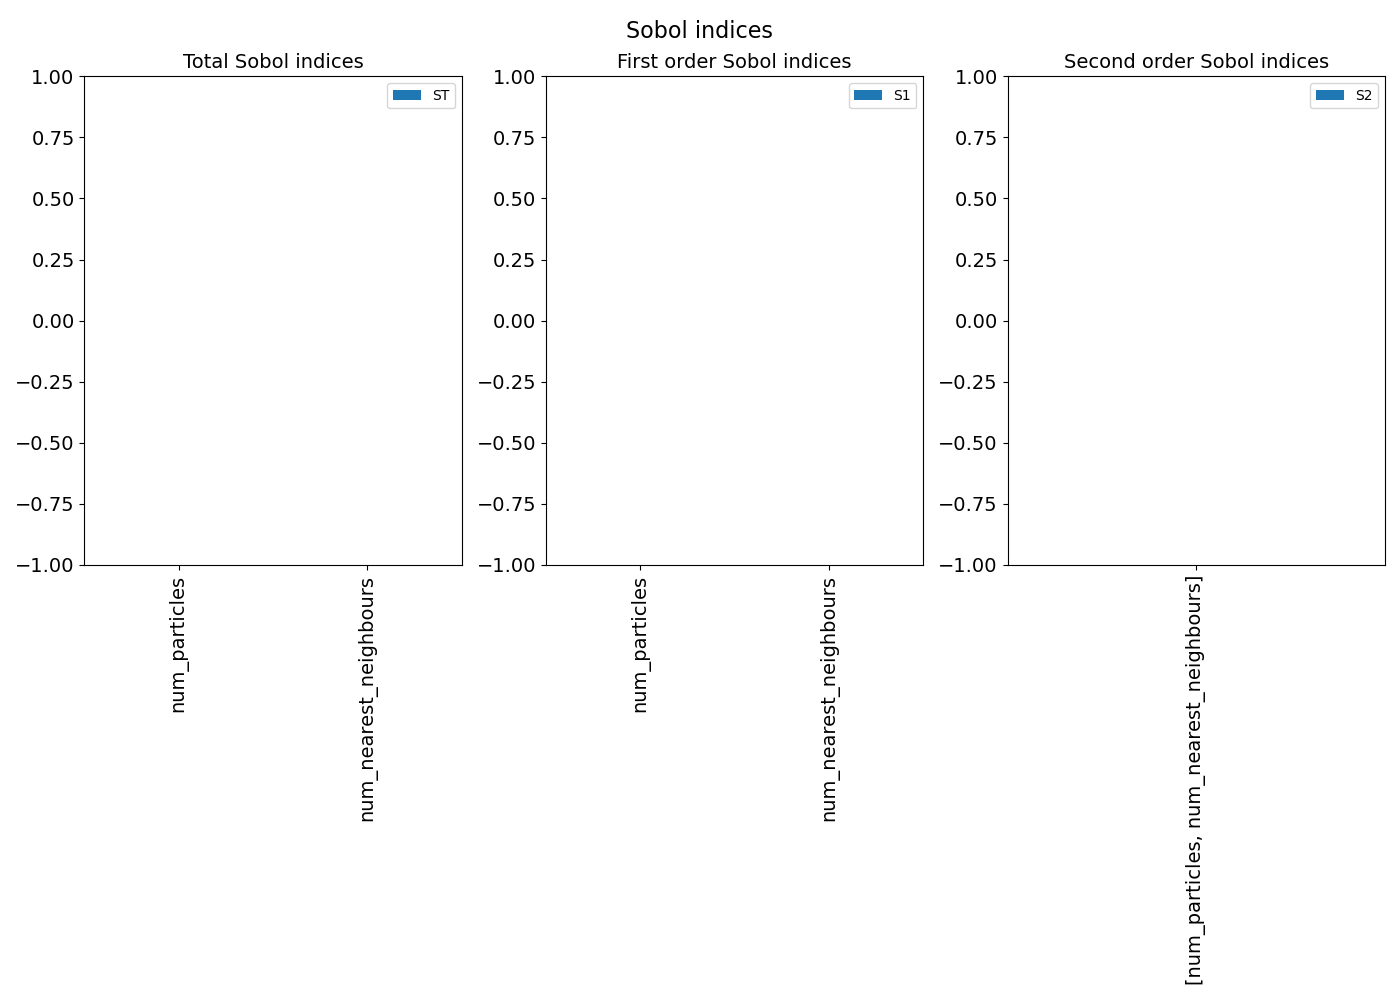

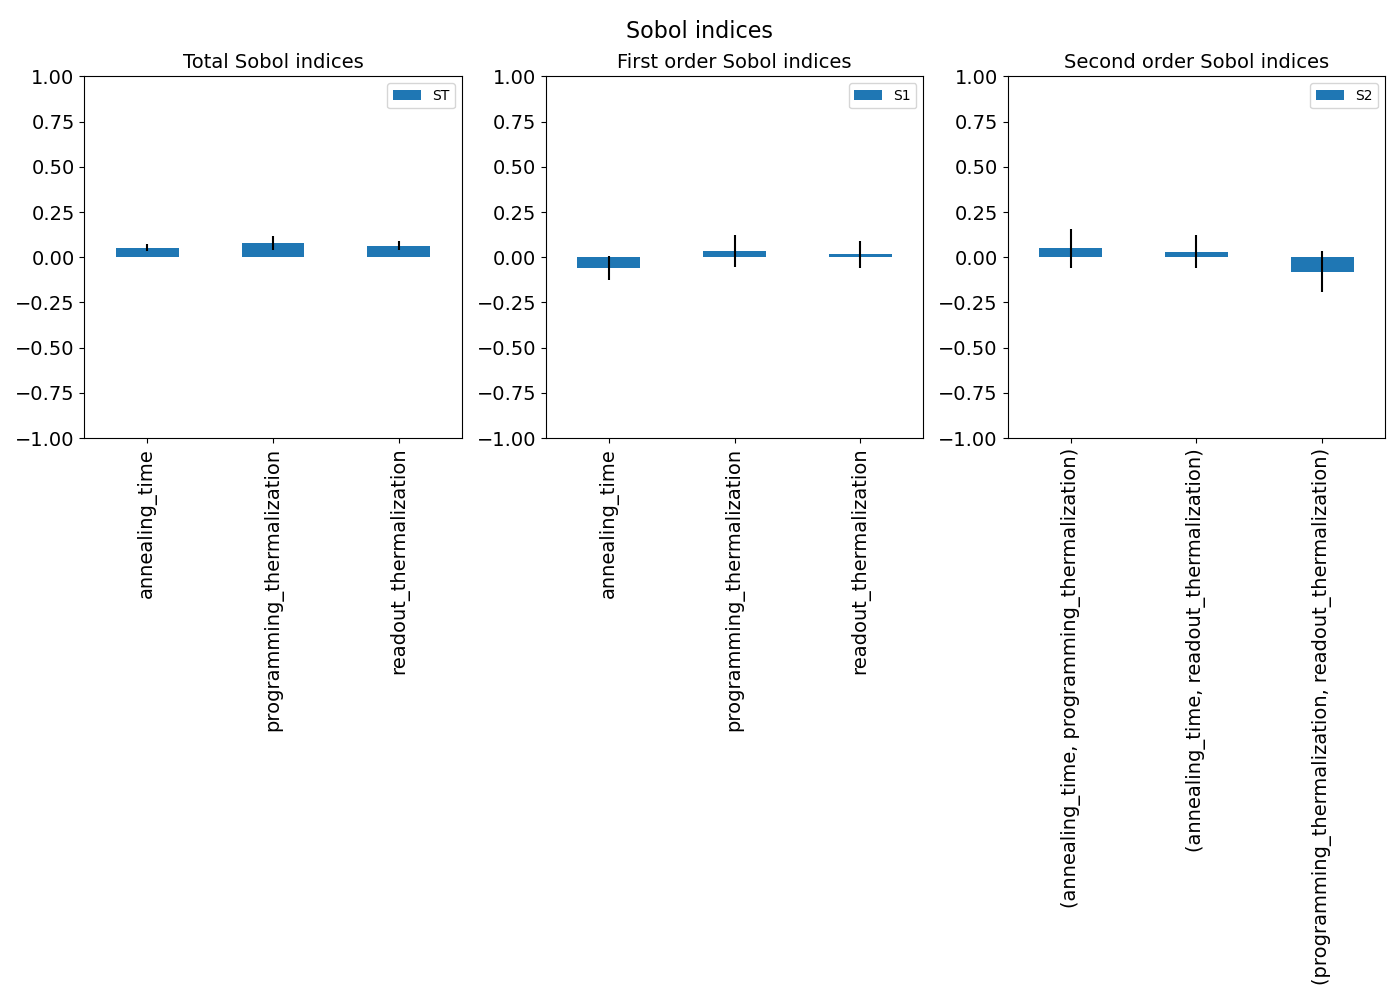

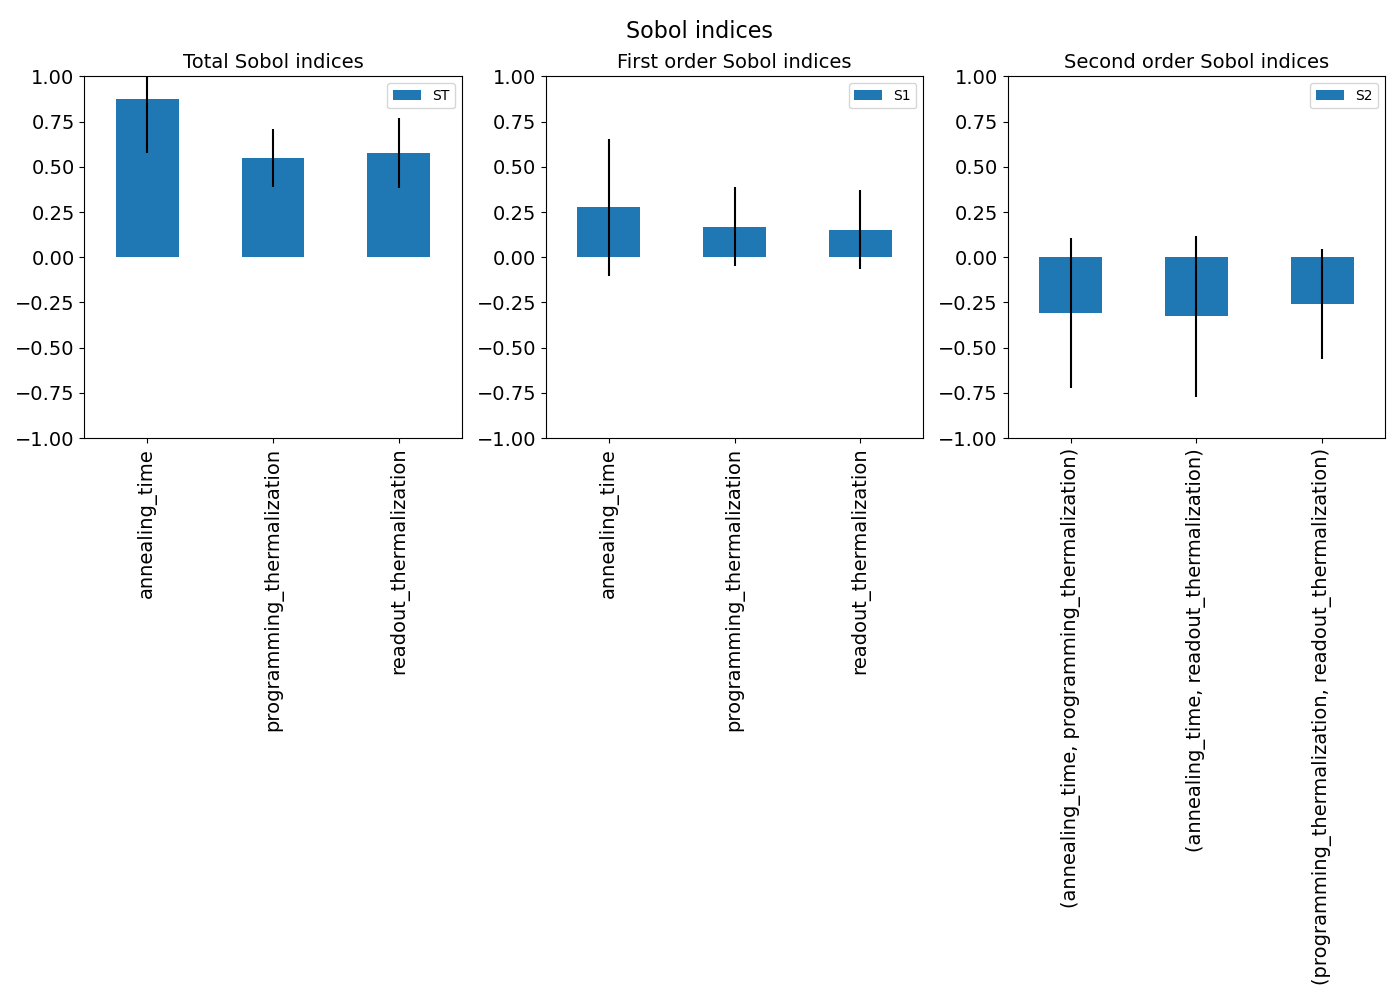

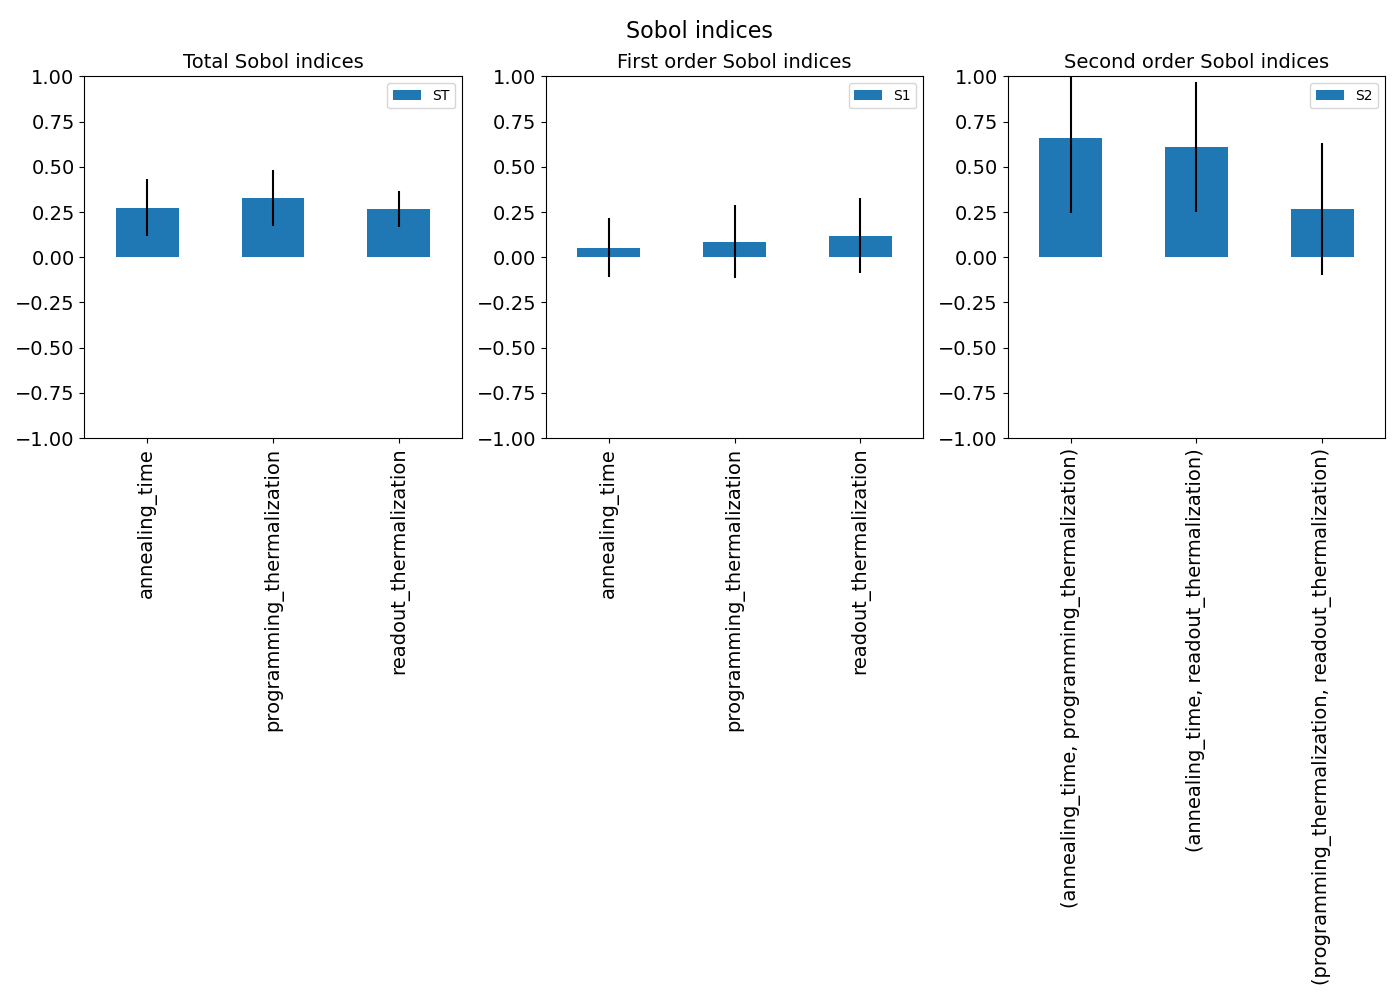

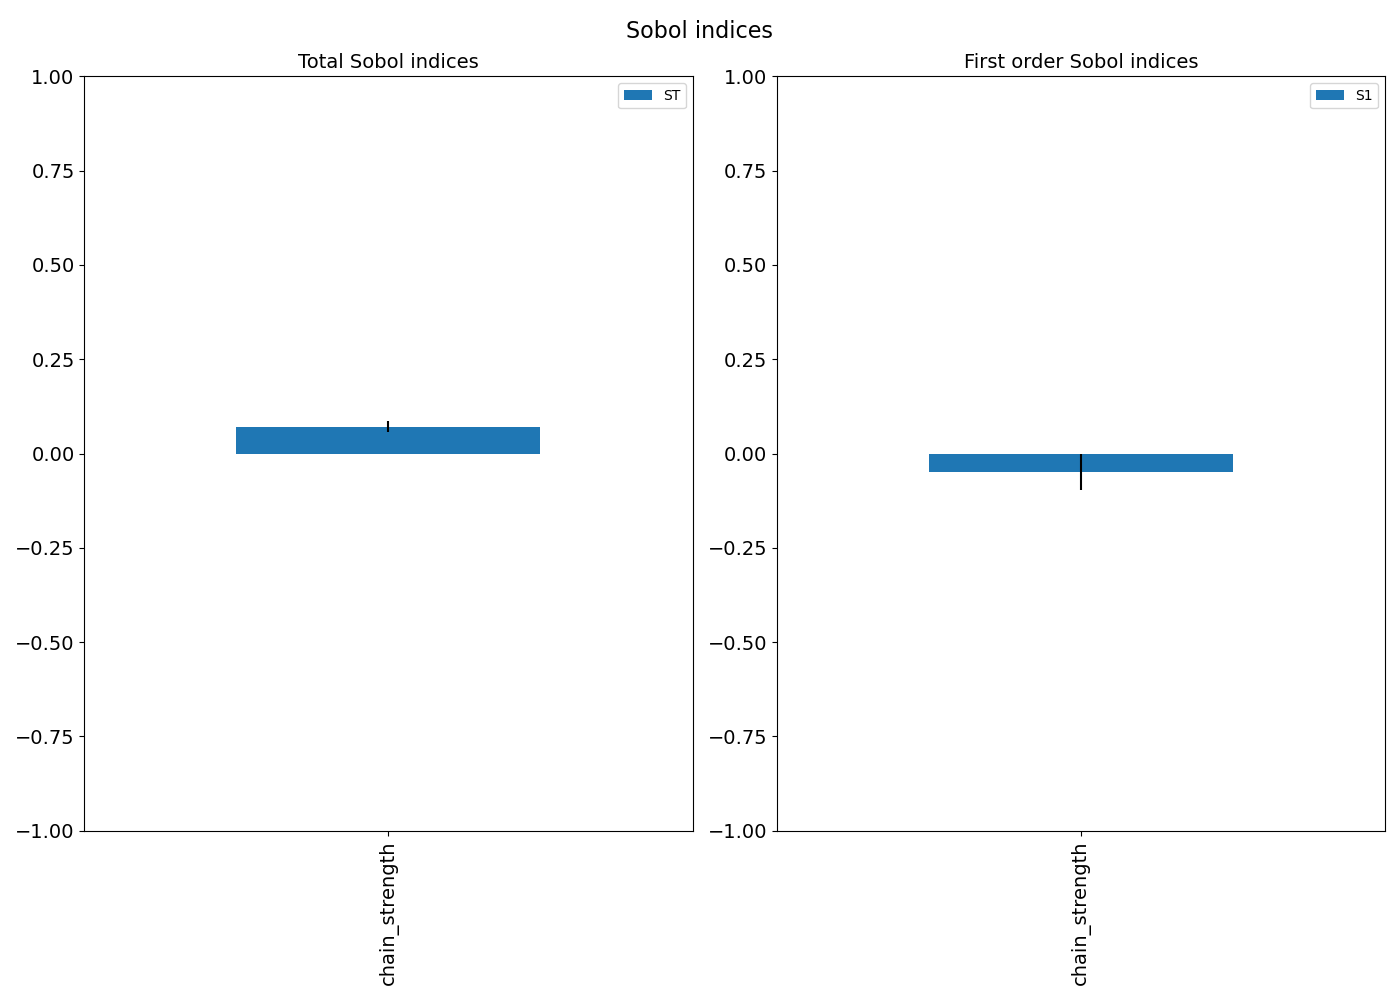

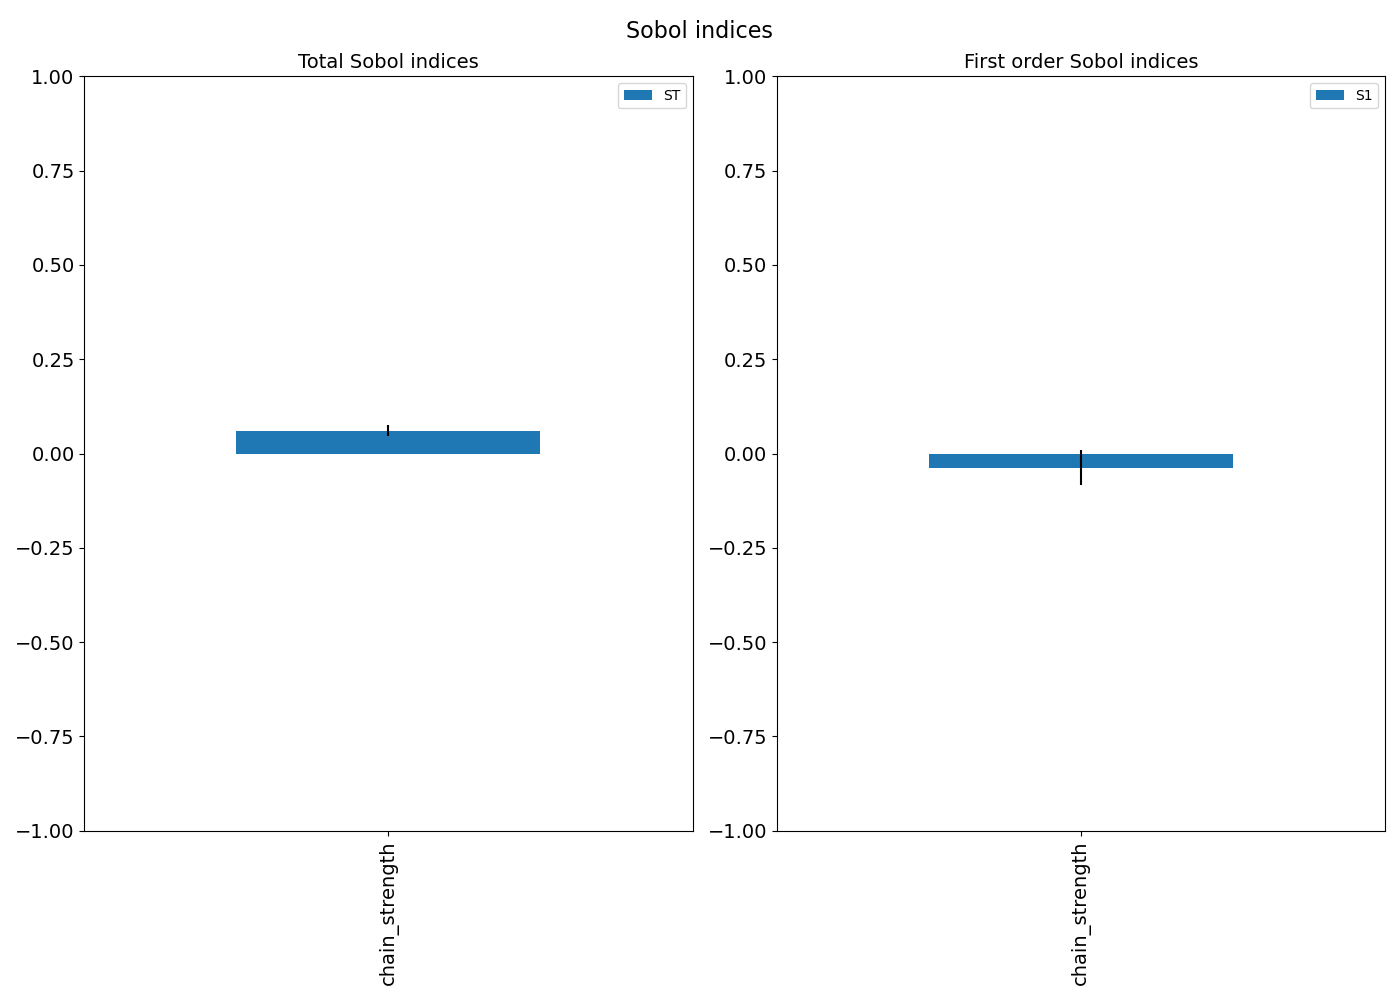

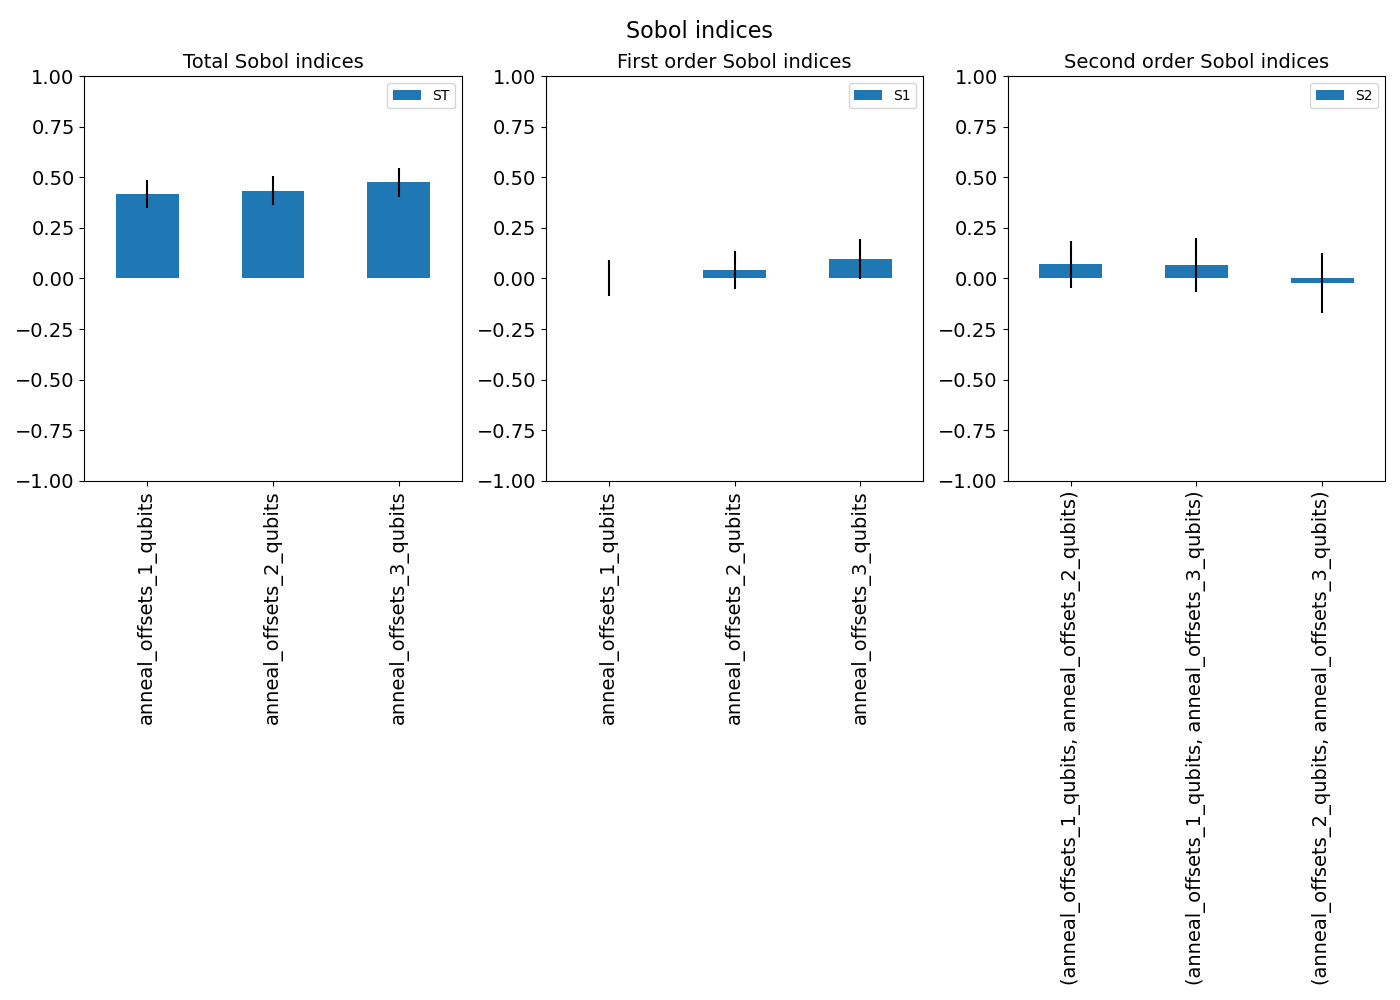

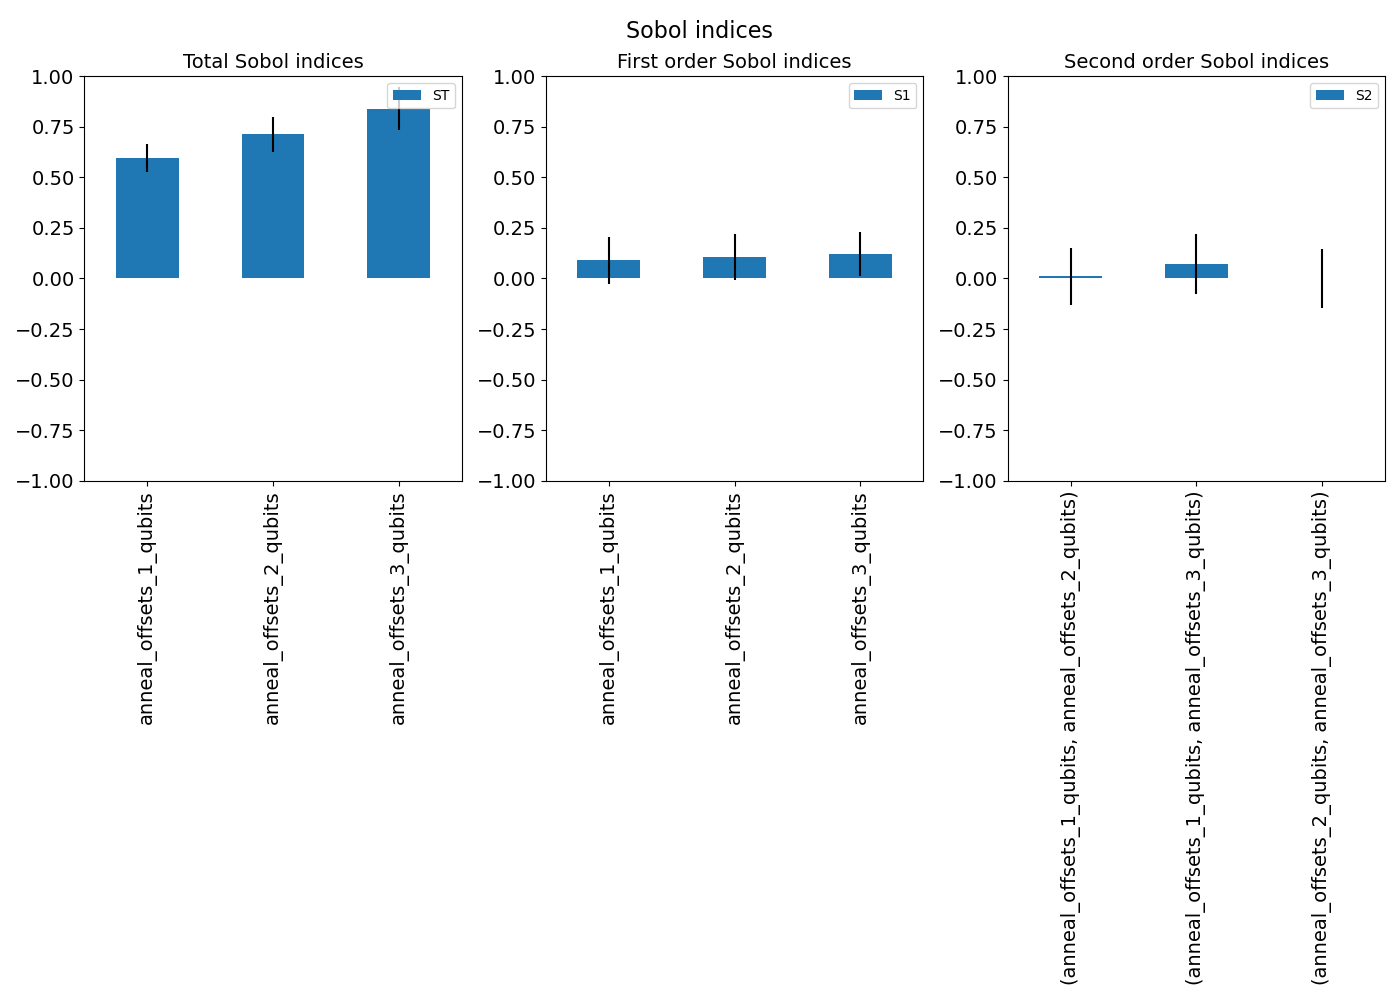

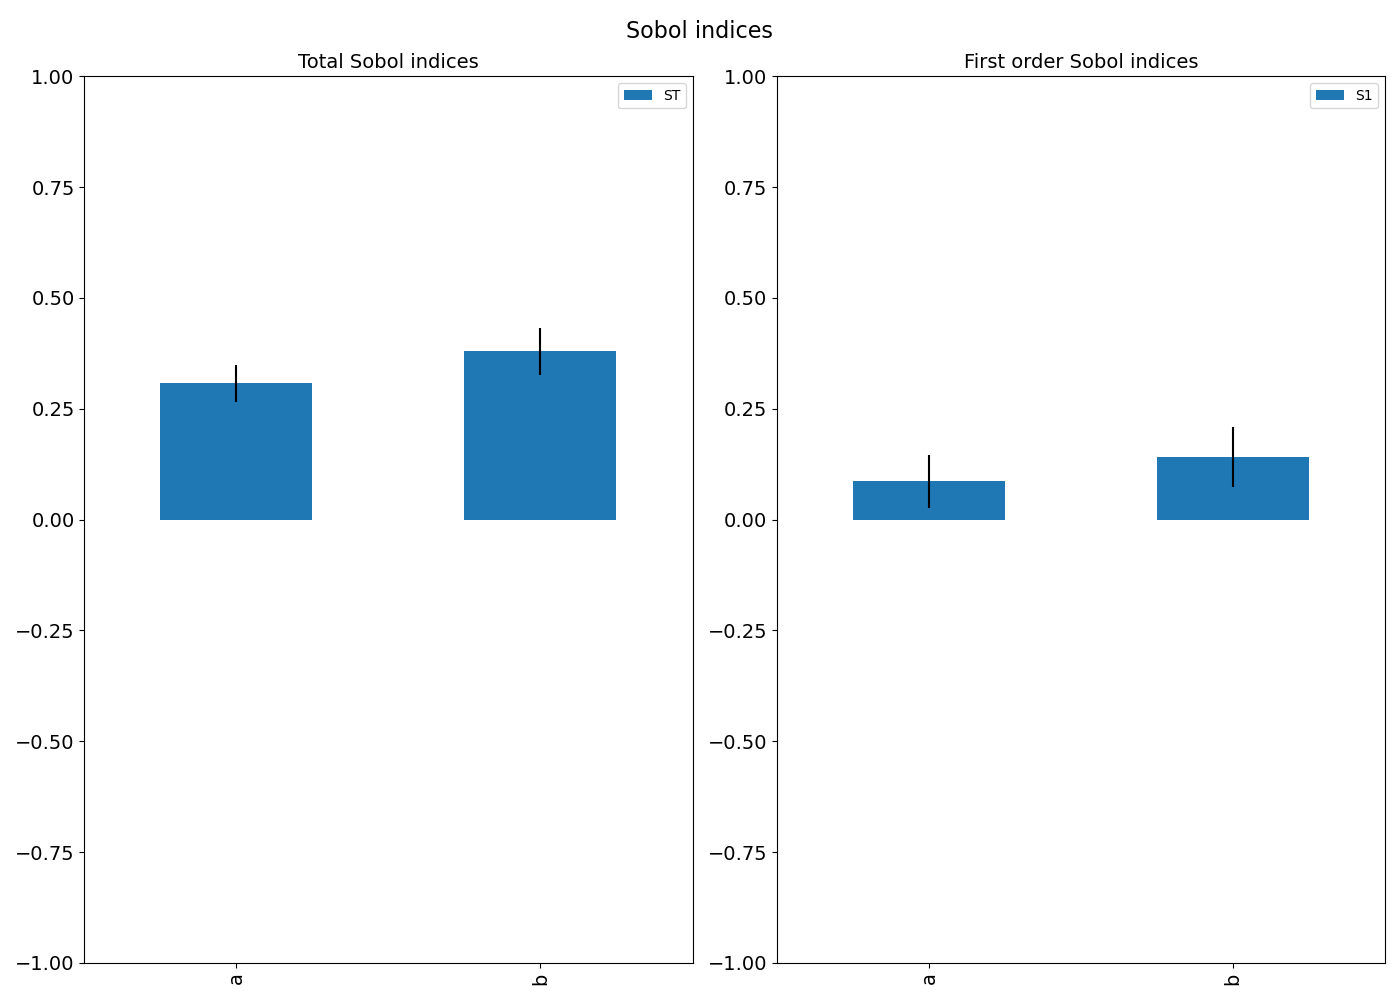

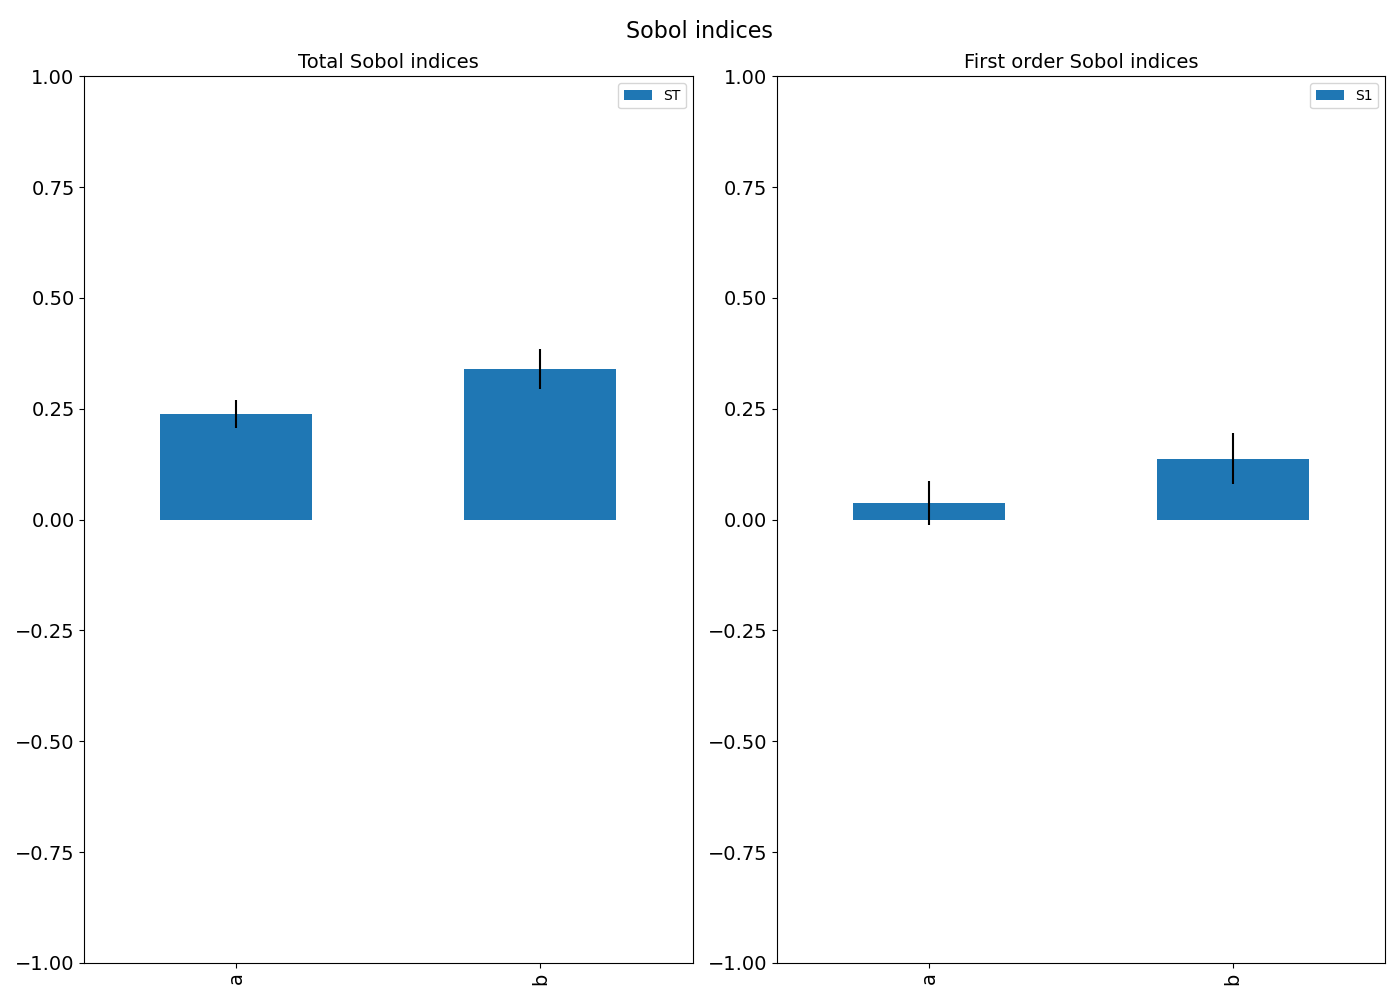

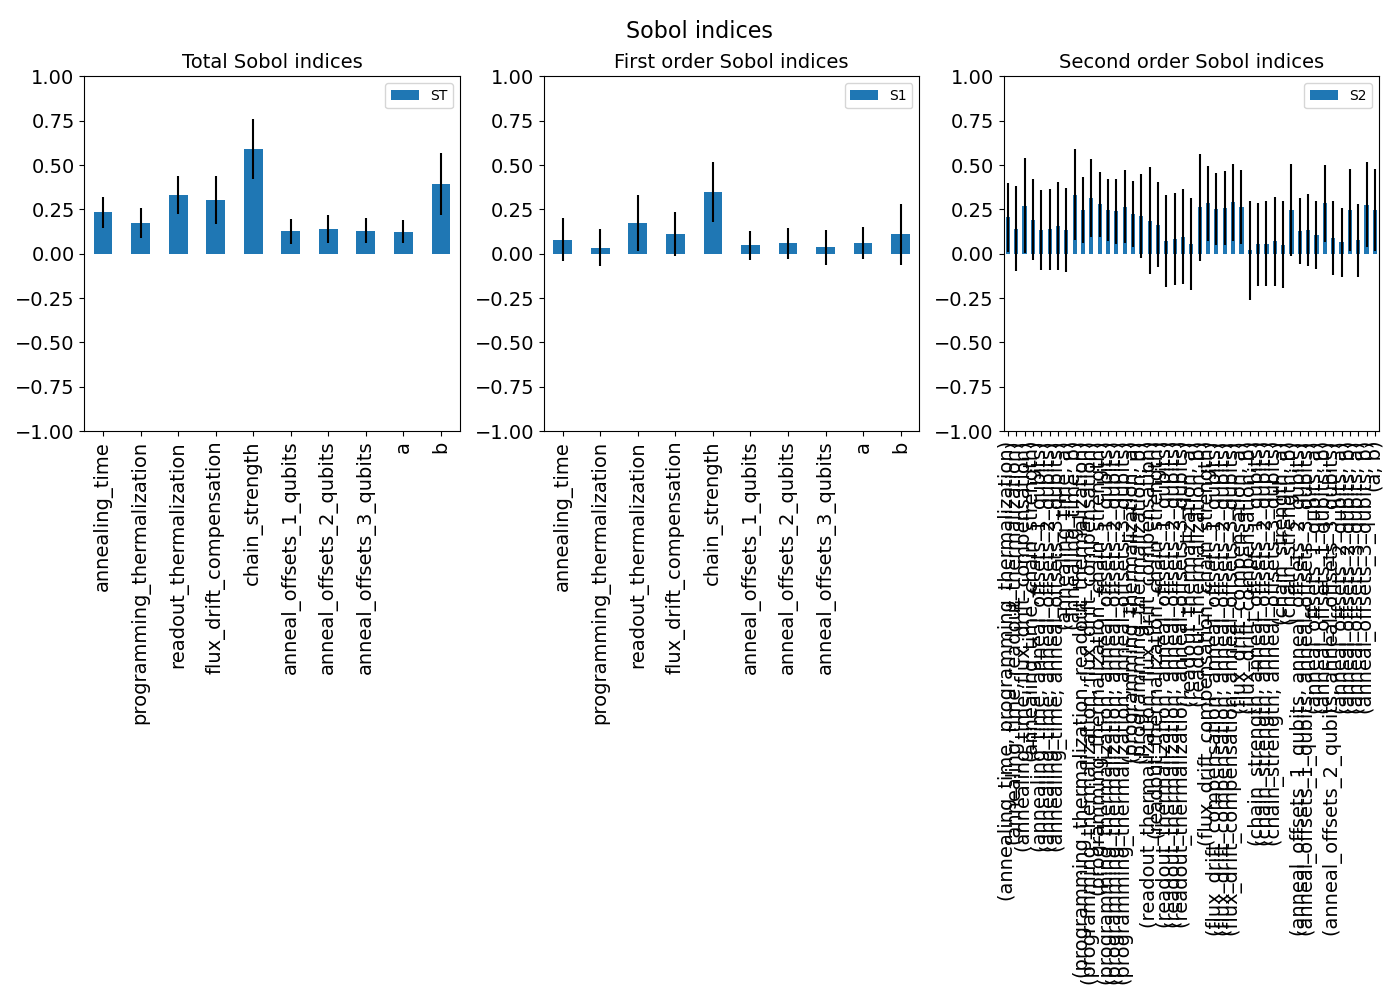

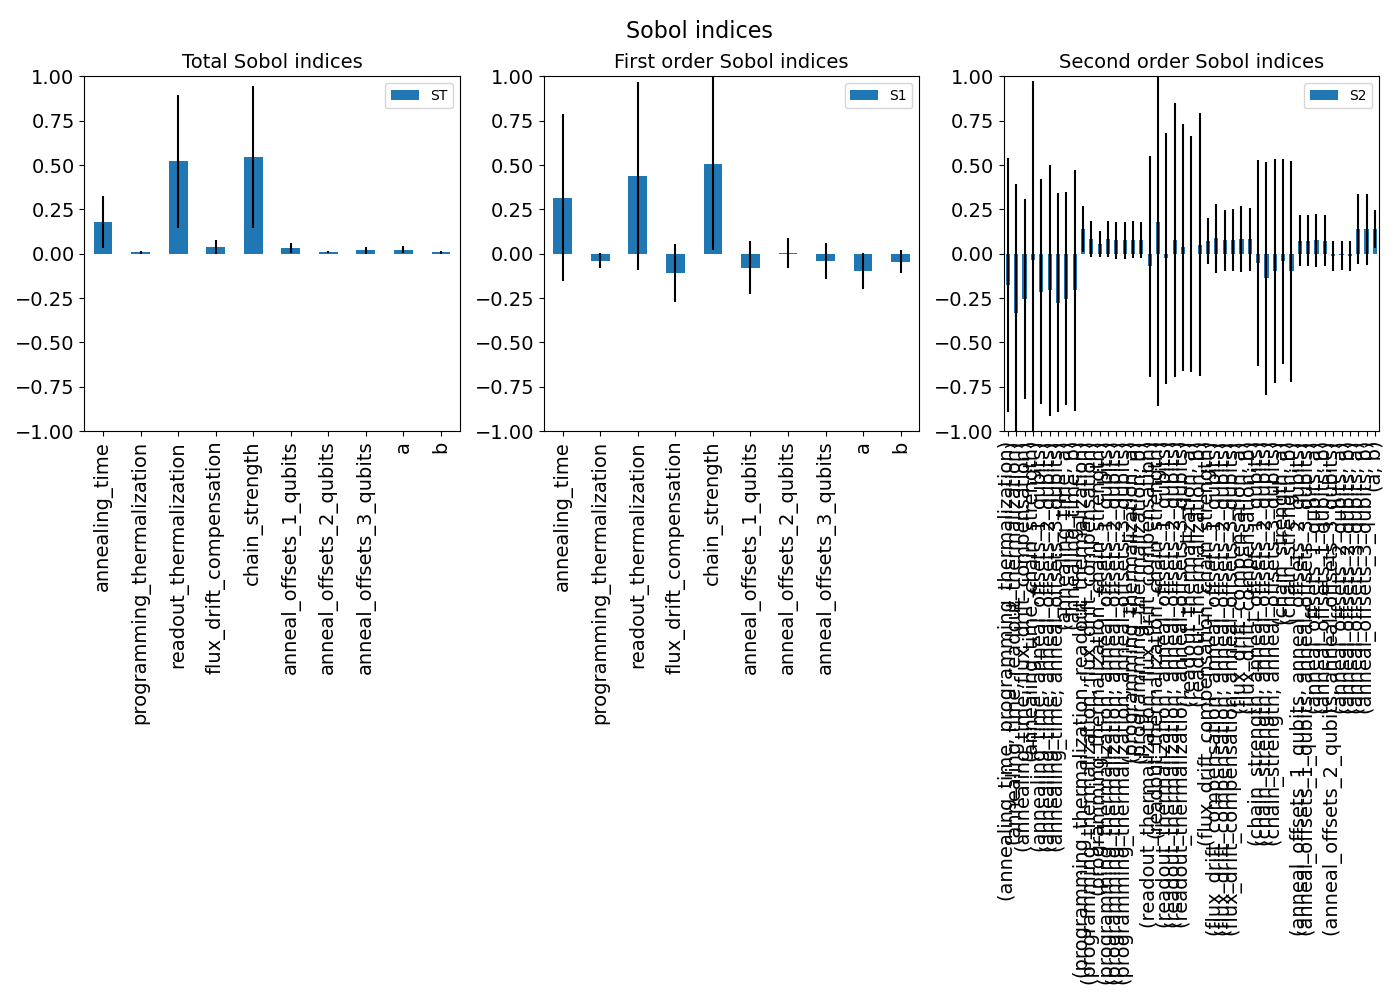

In [60]:
for key in dict_salib_analyses.keys():
    print(key)
    if dict_salib_analyses[key] is not None:
        print('  ', len(dict_salib_analyses[key]), [id for id in range(len(dict_salib_analyses[key]))])
        for subkey in range(len(dict_salib_analyses[key])):
            print('  ', key, subkey, dict_salib_problem[key][subkey]['num_vars'])
            if dict_salib_problem[key][subkey]['num_vars']:
                _plot = dict_salib_analyses[key][subkey].plot()
                _plot[0].figure.set_size_inches(14, 10)
                _plot[0].figure.suptitle('Sobol indices', fontsize=16)
                _plot[0].set_title('Total Sobol indices', fontsize=14)
                _plot[1].set_title('First order Sobol indices', fontsize=14)
                if _plot.shape[0] == 3:
                    _plot[2].set_title('Second order Sobol indices', fontsize=14)
                for ax in _plot:
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    ax.tick_params(axis='both', which='minor', labelsize=12)
                    ax.set_ylim((-1.0, 1.0))
                plt.tight_layout()

                plt.savefig(f'03_inspect/02_figs/salib_analysis_{key}_{subkey}.png')
    else:
        print('  No analyses available for this study.')

In [61]:
dict_salib_problem[key][subkey]

{'num_vars': 10,
 'names': ['annealing_time',
  'programming_thermalization',
  'readout_thermalization',
  'flux_drift_compensation',
  'chain_strength',
  'anneal_offsets_1_qubits',
  'anneal_offsets_2_qubits',
  'anneal_offsets_3_qubits',
  'a',
  'b'],
 'bounds': array([[-2.59637311e-01,  3.24303805e+00],
        [ 0.00000000e+00,  2.25000000e+03],
        [ 0.00000000e+00,  2.25000000e+03],
        [ 0.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+01],
        [-6.50000000e-01,  6.50000000e-01],
        [-6.50000000e-01,  6.50000000e-01],
        [-6.50000000e-01,  6.50000000e-01],
        [-1.00000000e+00,  1.00000000e+00],
        [ 6.25000000e-02,  1.00000000e+00]])}

1
   1 1 [0]
     1 0 2
2
   2 1 [0]
     2 0 3
3
   3 1 [0]
     3 0 3
4
   4 1 [0]
     4 0 3
5
   5 4 [0, 1, 2, 3]
     5 0 1
     5 1 1
     5 2 3
     5 3 3
6
   6 2 [0, 1]
     6 0 2
     6 1 2
7
   7 1 [0]
     7 0 10
8
   8 1 [0]
     8 0 10


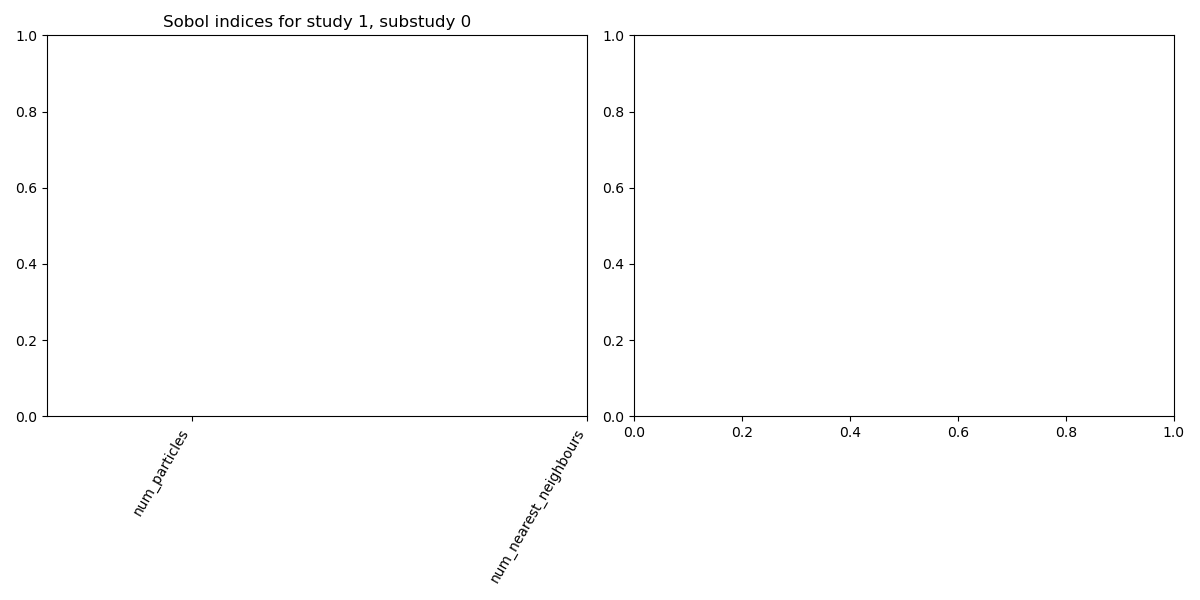

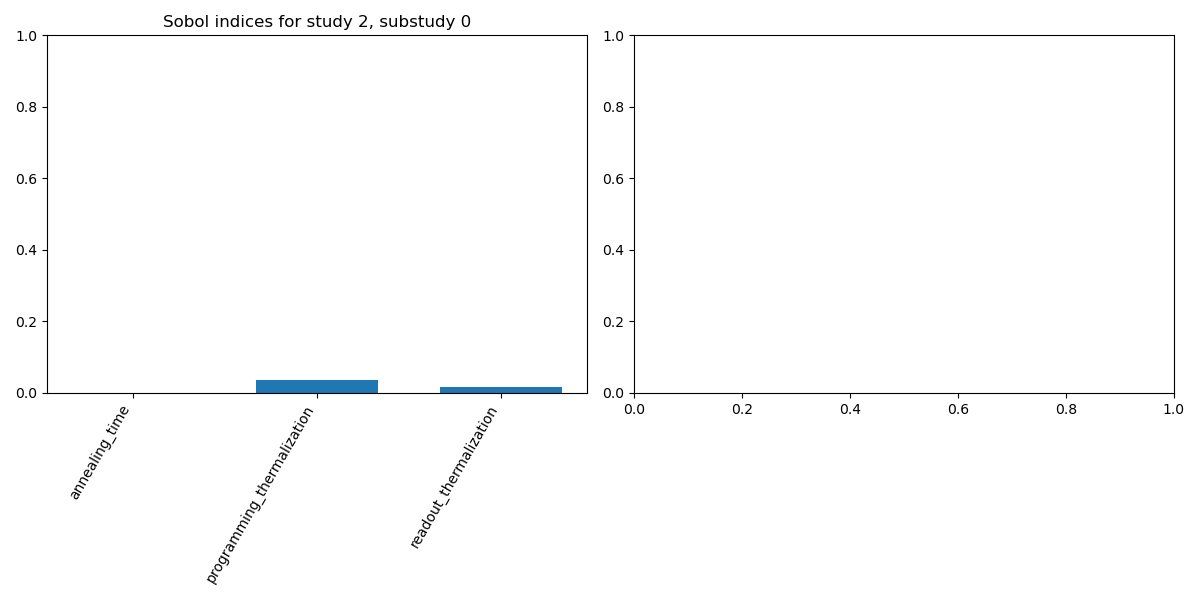

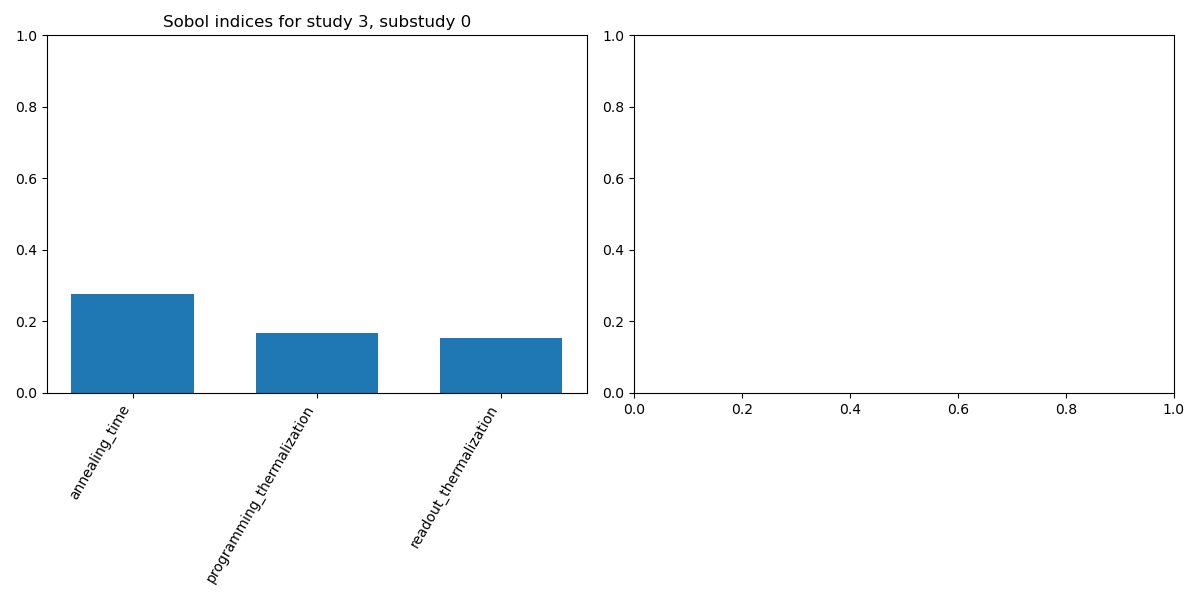

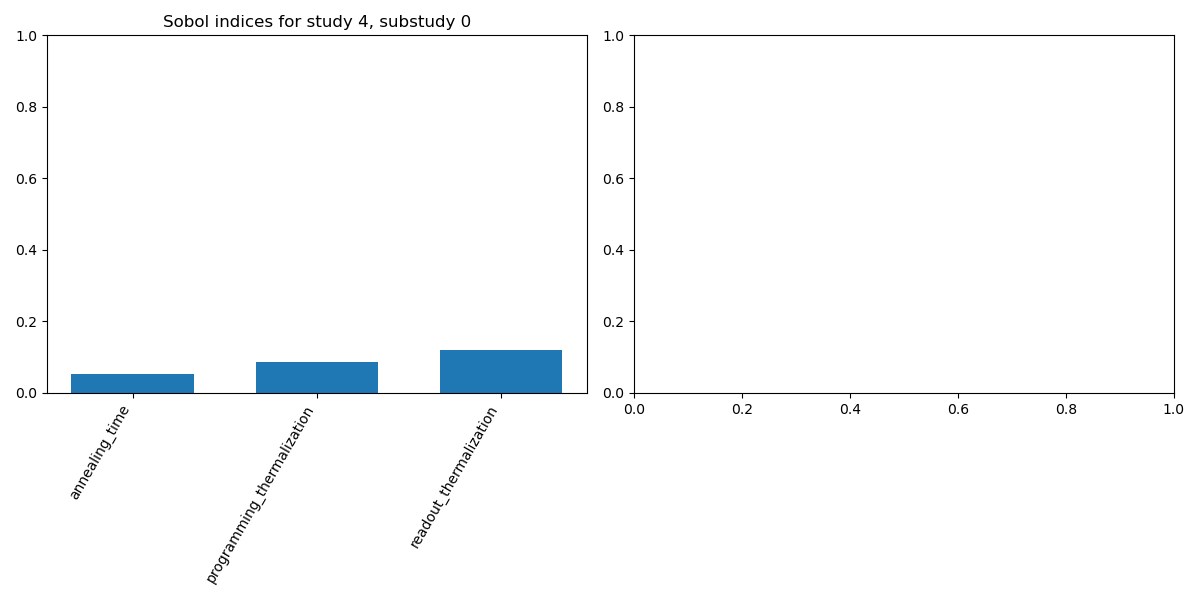

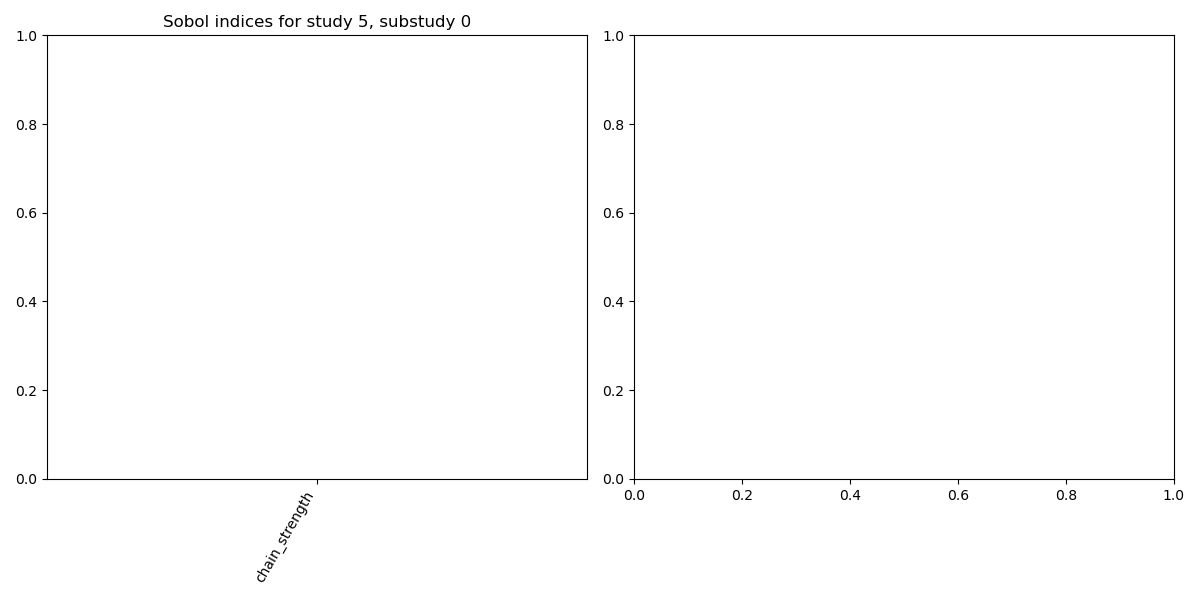

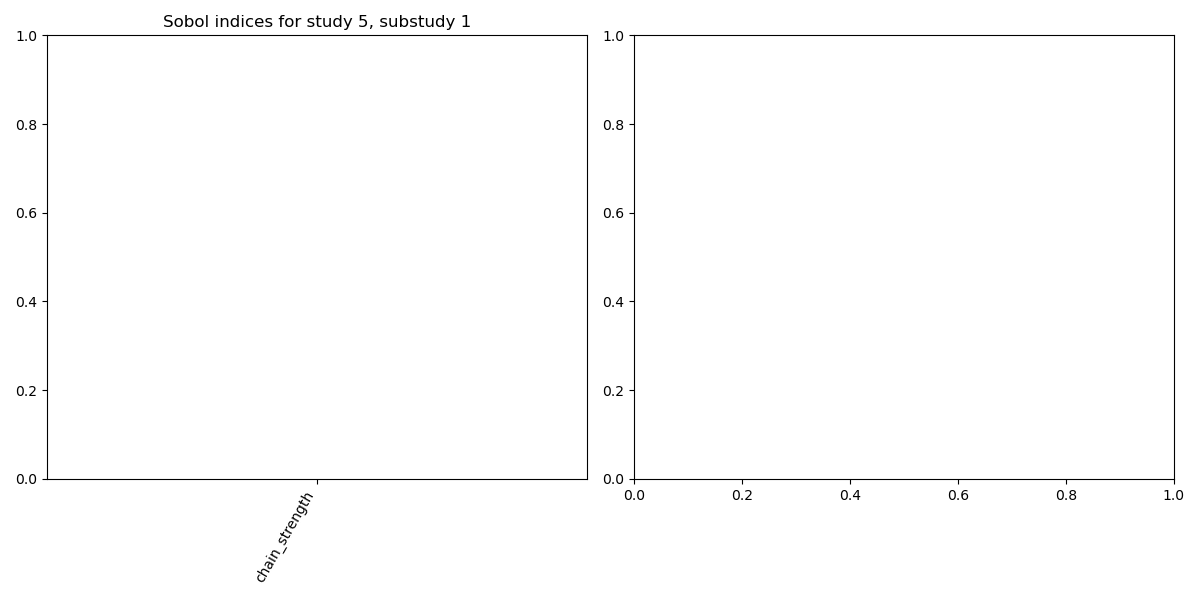

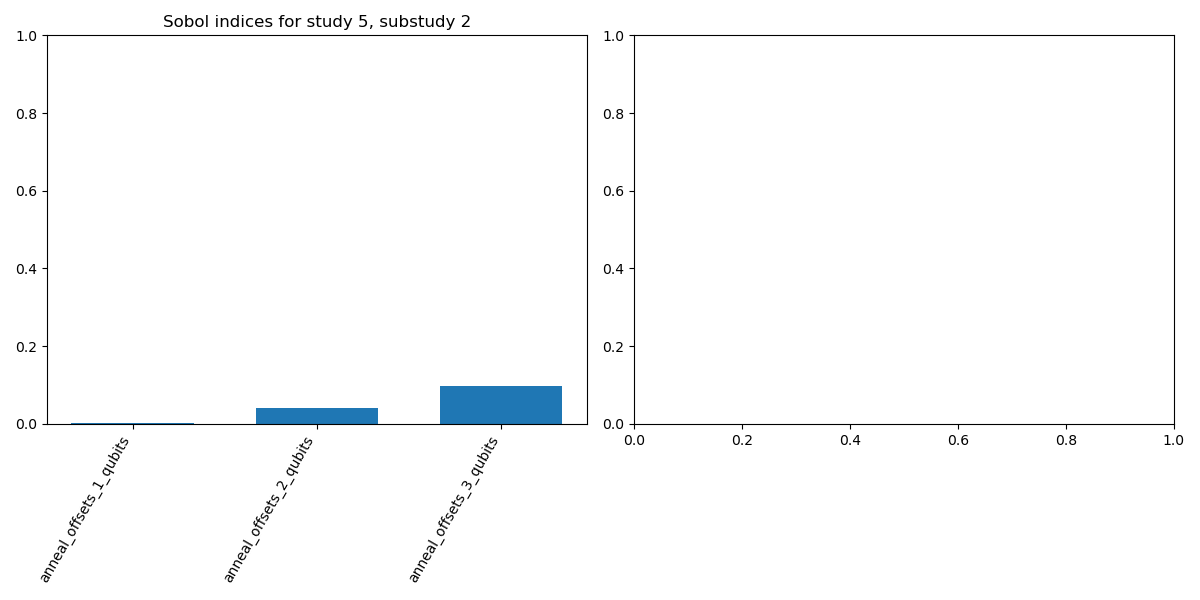

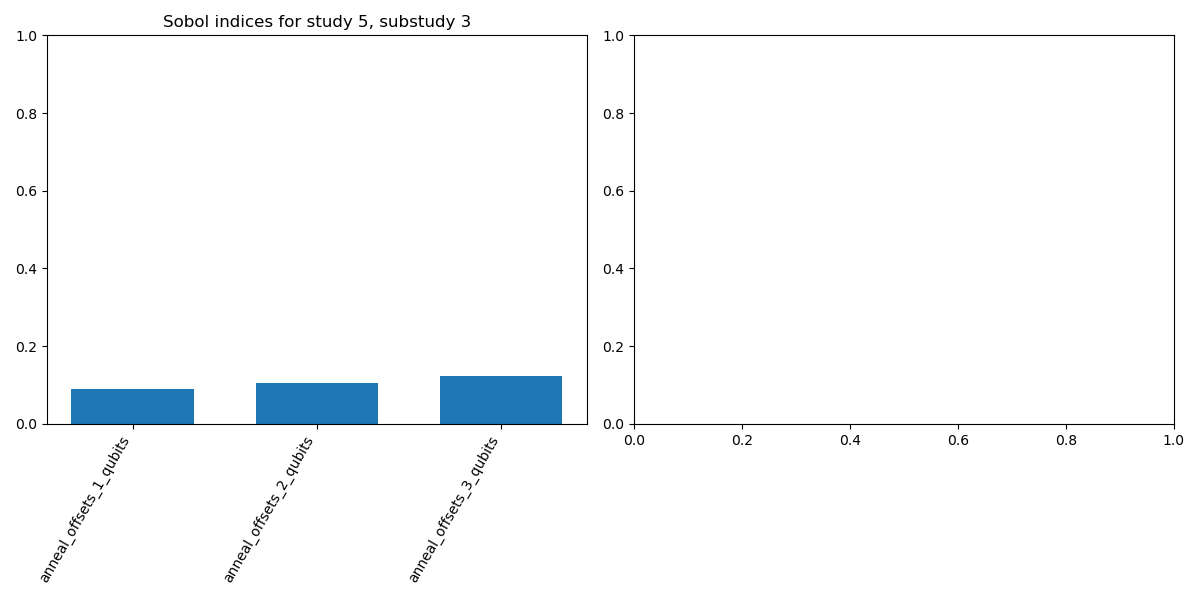

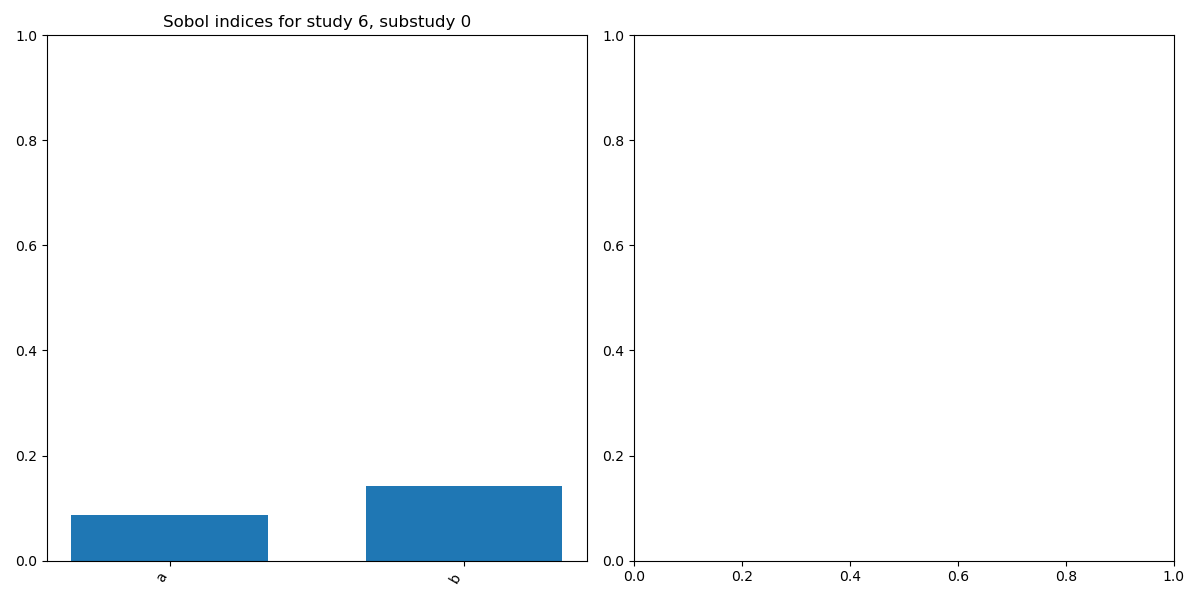

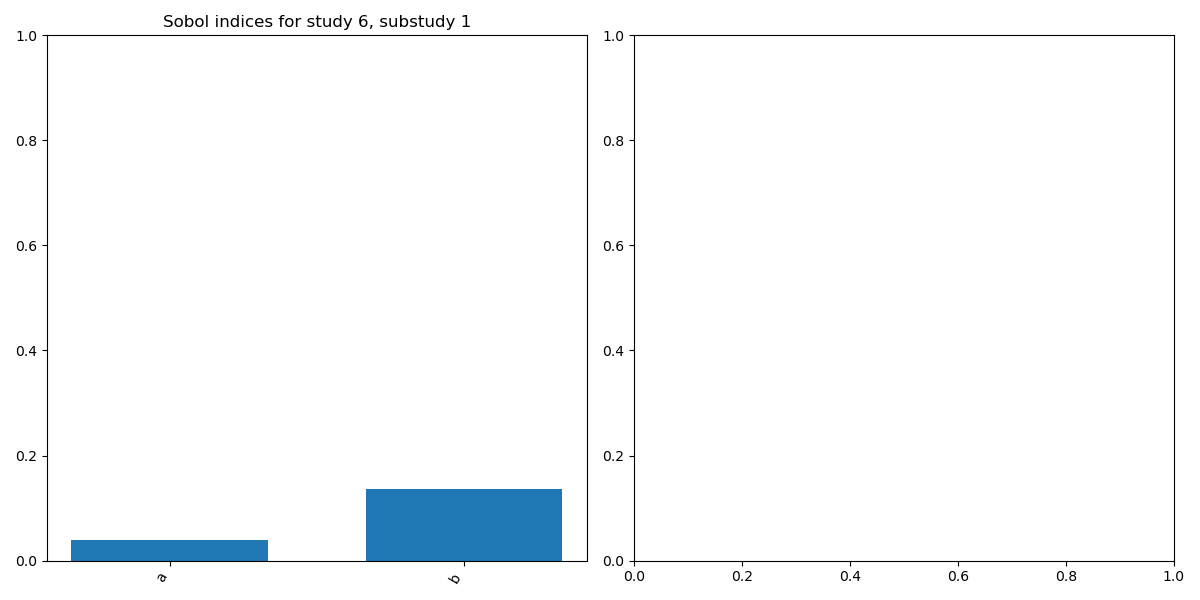

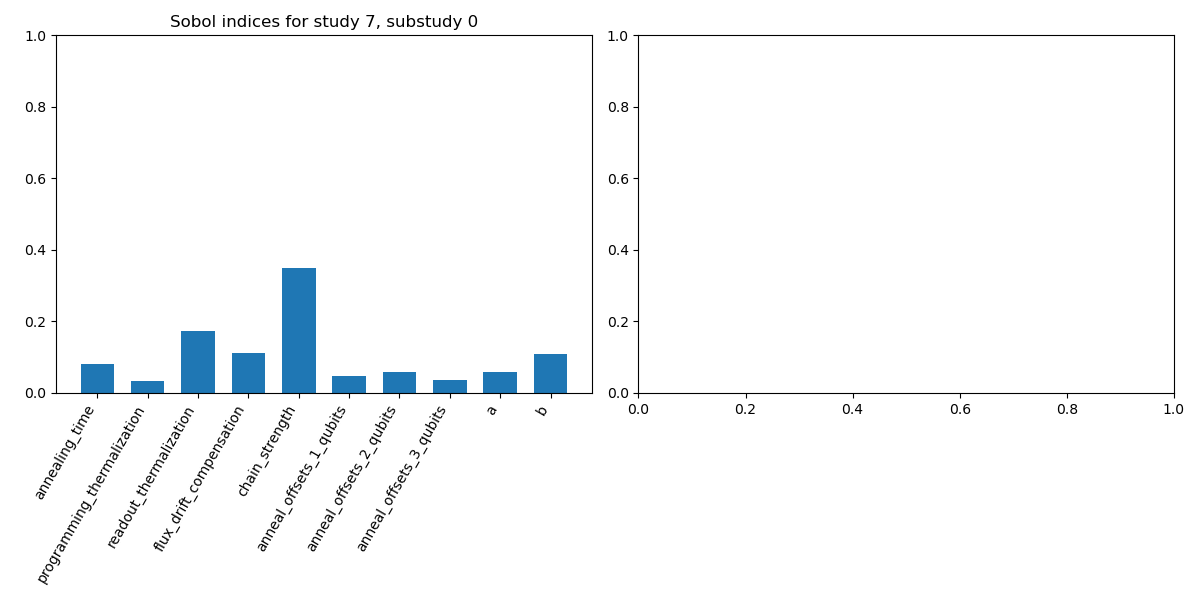

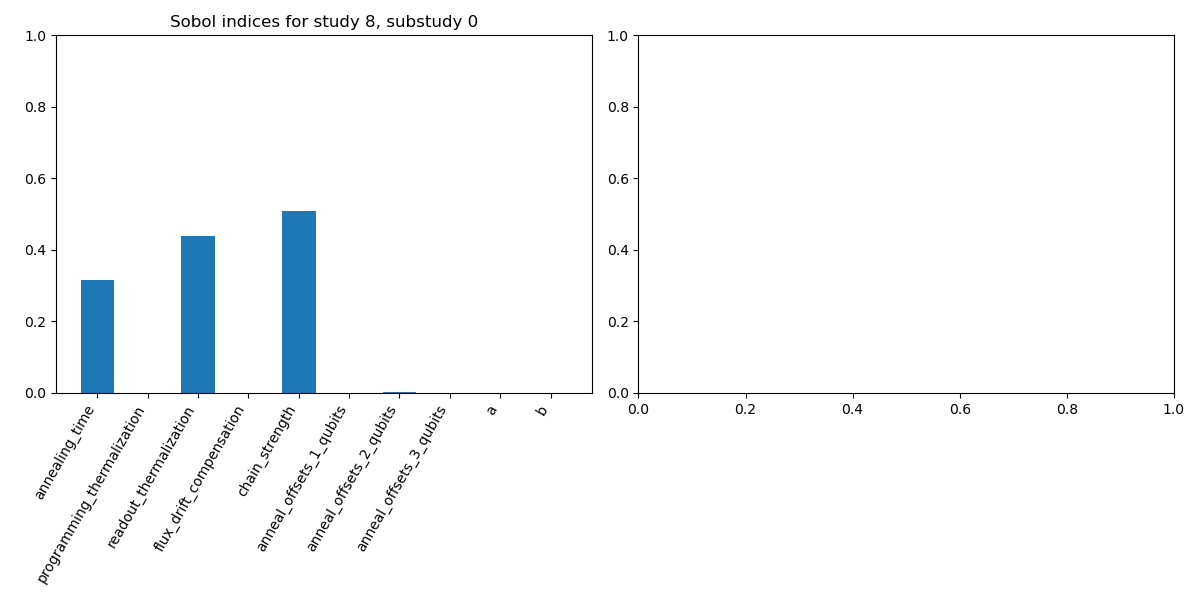

In [62]:
plt.close('all')
dict_plots = {}
bar_width = 0.1
bar_spacing = 0.15
for key in dict_salib_analyses.keys():
    print(key)
    dict_plots[key] = []
    if dict_salib_analyses[key] is not None:
        print('  ', key, len(dict_salib_analyses[key]), [id for id in range(len(dict_salib_analyses[key]))])
        for subkey in range(len(dict_salib_analyses[key])):
            print('    ', key, subkey, dict_salib_problem[key][subkey]['num_vars'])
            _fig, _axs = plt.subplots(1, 2, figsize=(12, 6))
            _num_vars = dict_salib_problem[key][subkey]['num_vars']
            _axs[0].set_title(f'Sobol indices for study {key}, substudy {subkey}')
            _axs[0].set_ylim(None, 1.0)
            _axs[0].bar(x = np.arange(0, _num_vars*(bar_spacing), (bar_spacing)), height=dict_salib_analyses[key][subkey]['S1'], width=0.1, tick_label=list(dict_salib_problem[key][subkey]['names']))
            _axs[0].set_xticklabels(_axs[0].get_xticklabels(),rotation=60, ha='right')
            _fig.tight_layout()
    else:
        print('  No analyses available for this study.')

In [63]:
dict_salib_problem[2][0]

{'num_vars': np.int32(3),
 'names': ['annealing_time',
  'programming_thermalization',
  'readout_thermalization'],
 'bounds': array([[5.e-01, 2.e+03],
        [0.e+00, 1.e+04],
        [0.e+00, 1.e+04]])}

In [64]:
dict_salib_analyses[4][0]

{'S1': array([0.05363603, 0.08649544, 0.11982342]),
 'S1_conf': array([0.16235597, 0.20072227, 0.20653727]),
 'ST': array([0.27370153, 0.32646016, 0.26832394]),
 'ST_conf': array([0.15711583, 0.15649251, 0.10031237]),
 'S2': array([[       nan, 0.65828269, 0.60903764],
        [       nan,        nan, 0.26564778],
        [       nan,        nan,        nan]]),
 'S2_conf': array([[       nan, 0.4150527 , 0.36138404],
        [       nan,        nan, 0.36438402],
        [       nan,        nan,        nan]])}

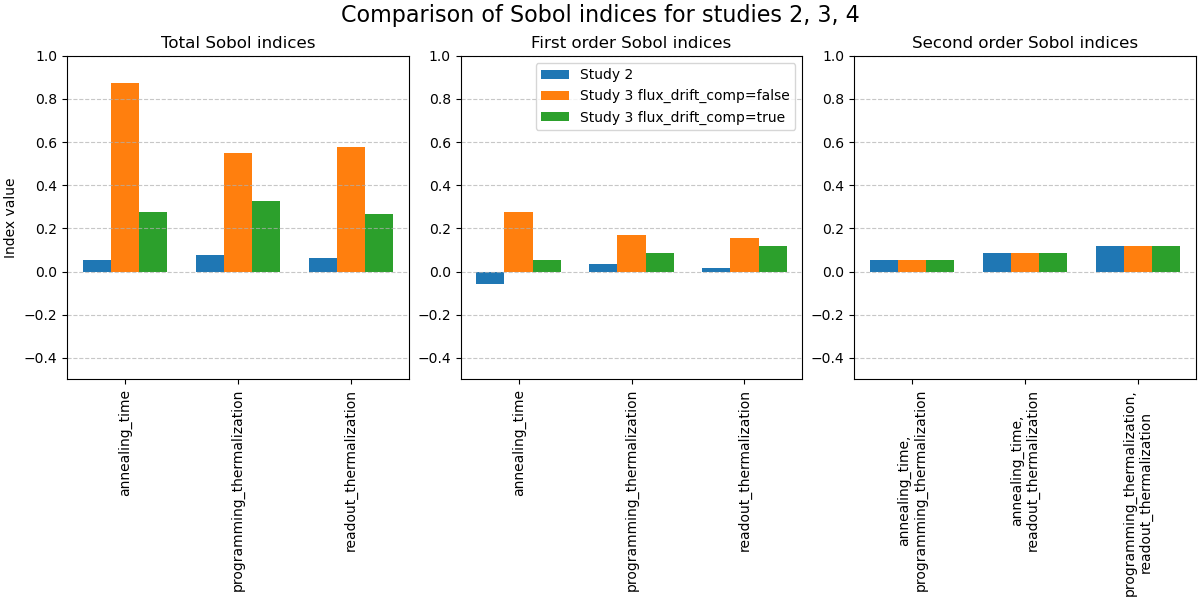

In [65]:
#####
# Compare 2 & 3 & 4
#####
plt.close('all')

x = np.arange(3)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

s2_ticklabels = [dict_salib_problem[2][0]['names'][0]+',\n'+dict_salib_problem[2][0]['names'][1],
                 dict_salib_problem[2][0]['names'][0]+',\n'+dict_salib_problem[2][0]['names'][2],
                 dict_salib_problem[2][0]['names'][1]+',\n'+dict_salib_problem[2][0]['names'][2]]
legend_labels = ['Study 2', 'Study 3 flux_drift_comp=false', 'Study 3 flux_drift_comp=true']
fig, axs = plt.subplots(nrows=1, ncols=3, layout='constrained', figsize=(12, 6))
for i, id_name in enumerate(['ST', 'S1', 'S2']):
#for i, id_name in enumerate(['S1']):
    multiplier = 0
    for study_id in range(2,5):
        offset = width * multiplier
        if id_name != 'S2':
            #values = [dict_salib_analyses[2][0][id_name][id], dict_salib_analyses[3][0][id_name][id], dict_salib_analyses[4][0][id_name][id]]
            #print(values)
            values = dict_salib_analyses[study_id][0][id_name]
            rects = axs[i].bar(x + offset, values, width, label=legend_labels[study_id-2])
            axs[i].set_xticks(x + width, dict_salib_problem[2][0]['names'], rotation=90)
        else:
            if id == 0:
                values = [dict_salib_analyses[study_id][0][id_name][0,1],
                           dict_salib_analyses[study_id][0][id_name][0,2],
                           dict_salib_analyses[study_id][0][id_name][1,2]]
            elif id == 1:
                values = [dict_salib_analyses[study_id][0][id_name][0,1],
                           dict_salib_analyses[study_id][0][id_name][0,2],
                           dict_salib_analyses[study_id][0][id_name][1,2]]
            elif id == 2:
                values = [dict_salib_analyses[study_id][0][id_name][0,1],
                           dict_salib_analyses[study_id][0][id_name][0,2],
                           dict_salib_analyses[study_id][0][id_name][1,2]]
            rects = axs[i].bar(x + offset, values, width, label=legend_labels[study_id-2])
            axs[i].set_xticks(x + width, s2_ticklabels, rotation=90)

        axs[i].set_ylim(-0.5, 1.0)
        axs[i].grid(axis='y', linestyle='--', alpha=0.7)
        multiplier += 1
        #axs[i].bar_label(rects, padding=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Index value')
axs[0].set_title('Total Sobol indices')
axs[1].set_title('First order Sobol indices')
axs[2].set_title('Second order Sobol indices')
axs[1].legend(loc='upper right')
fig.suptitle('Comparison of Sobol indices for studies 2, 3, 4', fontsize=16)

plt.show()
plt.savefig('03_inspect/02_figs/sobol_indices_comparison_2_3_4.svg')

In [66]:
dict_salib_analyses[7][0]

{'S1': array([0.08021193, 0.03284948, 0.17332476, 0.1112592 , 0.34842887,
        0.04774608, 0.05797548, 0.03595092, 0.05903103, 0.1088492 ]),
 'S1_conf': array([0.12021207, 0.10399777, 0.15677572, 0.12582916, 0.17028059,
        0.0807757 , 0.08619577, 0.09803037, 0.08964649, 0.17072401]),
 'ST': array([0.23250189, 0.17318982, 0.33117691, 0.3022703 , 0.58973043,
        0.12690357, 0.14028625, 0.12979423, 0.12404859, 0.39362945]),
 'ST_conf': array([0.08774973, 0.0831895 , 0.10666654, 0.1370569 , 0.17119315,
        0.06985509, 0.07720411, 0.06912938, 0.06483561, 0.17252578]),
 'S2': array([[       nan, 0.20590269, 0.14223678, 0.27185257, 0.1905572 ,
         0.13274399, 0.13859669, 0.1560834 , 0.13288674, 0.33159289],
        [       nan,        nan, 0.24524611, 0.31240936, 0.27900617,
         0.2472446 , 0.2383228 , 0.26544505, 0.22376244, 0.21434103],
        [       nan,        nan,        nan, 0.18591118, 0.164713  ,
         0.07313973, 0.08384588, 0.09690739, 0.05379729, 0.26

['annealing_time,\nprogramming_thermalization', 'annealing_time,\nreadout_thermalization', 'annealing_time,\nflux_drift_compensation', 'annealing_time,\nchain_strength', 'annealing_time,\nanneal_offsets_1_qubits', 'annealing_time,\nanneal_offsets_2_qubits', 'annealing_time,\nanneal_offsets_3_qubits', 'annealing_time,\na', 'annealing_time,\nb', 'programming_thermalization,\nreadout_thermalization', 'programming_thermalization,\nflux_drift_compensation', 'programming_thermalization,\nchain_strength', 'programming_thermalization,\nanneal_offsets_1_qubits', 'programming_thermalization,\nanneal_offsets_2_qubits', 'programming_thermalization,\nanneal_offsets_3_qubits', 'programming_thermalization,\na', 'programming_thermalization,\nb', 'readout_thermalization,\nflux_drift_compensation', 'readout_thermalization,\nchain_strength', 'readout_thermalization,\nanneal_offsets_1_qubits', 'readout_thermalization,\nanneal_offsets_2_qubits', 'readout_thermalization,\nanneal_offsets_3_qubits', 'readout_

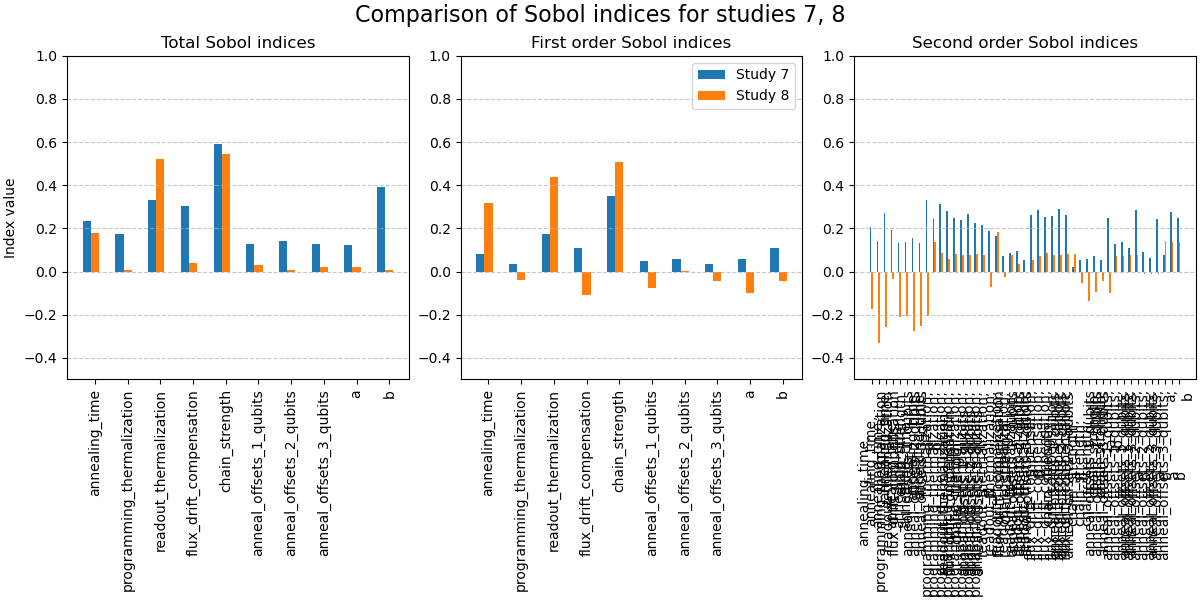

In [67]:
#####
# Compare 7 & 8
#####
import itertools
plt.close('all')

x = np.arange(10)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

s2_ticklabels = [i[0]+',\n'+i[1] for i in itertools.combinations(dict_salib_problem[7][0]['names'], 2)]
print(s2_ticklabels)
legend_labels = ['Study 7', 'Study 8']
fig, axs = plt.subplots(nrows=1, ncols=3, layout='constrained', figsize=(12, 6))
for i, id_name in enumerate(['ST', 'S1', 'S2']):
#for i, id_name in enumerate(['S1']):
    multiplier = 0
    for study_id in range(7,9):
        offset = width * multiplier
        if id_name != 'S2':
            #values = [dict_salib_analyses[2][0][id_name][id], dict_salib_analyses[3][0][id_name][id], dict_salib_analyses[4][0][id_name][id]]
            #print(values)
            values = dict_salib_analyses[study_id][0][id_name]
            rects = axs[i].bar(x + offset, values, width, label=legend_labels[study_id-7])
            axs[i].set_xticks(x + width, dict_salib_problem[7][0]['names'], rotation=90)
        else:
            values = [dict_salib_analyses[study_id][0][id_name][i,j] for i in range(0,10) for j in range(i+1, 10)] 
            print(values)
            rects = axs[i].bar(np.arange(len(values)) + offset, values, width, label=legend_labels[study_id-7])
            axs[i].set_xticks(np.arange(len(values)) + width, s2_ticklabels, rotation=90)

        axs[i].set_ylim(-0.5, 1.0)
        axs[i].grid(axis='y', linestyle='--', alpha=0.7)
        multiplier += 1
        #axs[i].bar_label(rects, padding=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Index value')
axs[0].set_title('Total Sobol indices')
axs[1].set_title('First order Sobol indices')
axs[2].set_title('Second order Sobol indices')
axs[1].legend(loc='upper right')
fig.suptitle('Comparison of Sobol indices for studies 7, 8', fontsize=16)

plt.show()
plt.savefig('03_inspect/02_figs/sobol_indices_comparison_7_8.svg')